# **Stock Price Prediction Using RNNs**

### By **Tejashri Pilla & Ruchika Janefalkar (ML-C72)**

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them
def load_aggregate_stock_data(folder_path):
    """
	Function to aggregate stock data from multiple CSV files.
	
	Parameters:
	folder_path: Path of the folder where all CSV files are located.
	
	Returns:
	pandas.DataFrame: Combined dataframe with all stock data
	"""
    # define empty DataFrame for aggregated data
    stock_df = []
    
    # get the list of all csv files in mentioned folder path
    file_list = glob.glob(os.path.join(folder_path, "*.csv"))

    for file in file_list:
        # extract stock name from file name
        stock_name = os.path.basename(file).split('_')[0]
        
        # Read the CSV files as data frames
        df = pd.read_csv(file)

        # Drop unnecessary columns
        df = df.drop('Name', axis=1)

        # Append the stock names into the columns of their respective data frames (except Date column)
        df.columns = ['Date'] + [f'{stock_name}_{col}' for col in df.columns[1:]]

        # Convert Date column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Append the df to the stock df list
        stock_df.append(df)

    # Join the data frames into one
    merged_df = stock_df[0]
    for df in stock_df[1:]:
        merged_df = pd.merge(merged_df, df, on='Date', how='outer')

    # Reset the index and return the Dataframe
    return merged_df.sort_values('Date').reset_index(drop=True)

In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

base_dir = 'RNN_Stocks_Data/'

# Call the above function to get combined dataframe for all 4 stocks merged by Date column
combined_stock_df = load_aggregate_stock_data(base_dir)
print(combined_stock_df.head())

        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
1 2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2 2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
3 2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
4 2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Close  \
0    80.81 

In [4]:
# View specifics of the data

print("\033[1m First 5 Rows: \033[0m")
print(combined_stock_df.head())

# View the shape of the data
print("\n\033[1m Shape of the Data: \033[0m")
print(combined_stock_df.shape)

# View column names
print("\n\033[1m Column Names: \033[0m")
print(combined_stock_df.columns.tolist())

# View data types of each column
print("\n\033[1m Data Types: \033[0m")
print(combined_stock_df.dtypes)

# Information about the data frame
print("\n\033[1m Information about the data frame: \033[0m")
print(combined_stock_df.info())

# View summary statistics
print("\n\033[1m Summary Statistics: \033[0m")
print(combined_stock_df.describe())

# Check for missing values
print("\n\033[1m Missing Values per Column: \033[0m")
print(combined_stock_df.isnull().sum())

 First 5 Rows: 
        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
1 2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2 2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
3 2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
4 2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Clos

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
# Handle Missing Values

print("\n\033[1m Missing Values per Column (Before): \033[0m")
print(combined_stock_df.isnull().sum())

print("\n\033[1m Missing Data Entries: \033[0m")
print(combined_stock_df[combined_stock_df.isnull().any(axis=1)])

# For stock data, we can use forward fill or backward fill
# Forward fill is more appropriate as it uses the last known value
combined_stock_df = combined_stock_df.fillna(method='ffill')

print("\n\033[1m Missing Values per Column (After): \033[0m")
print(combined_stock_df.isnull().sum())


 Missing Values per Column (Before): 
Date            0
AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
dtype: int64

 Missing Data Entries: 
           Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
1068 2010-04-01        NaN        NaN       NaN         NaN          NaN   
2913 2017-07-31    1019.05    1019.05    987.02      987.78    7352063.0   

      GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
1068         NaN         NaN        NaN          NaN  ...    128.95    129.31   
2913       960.0      961.19     941.72        945.5  ...       NaN    144.93   

      IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  \


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

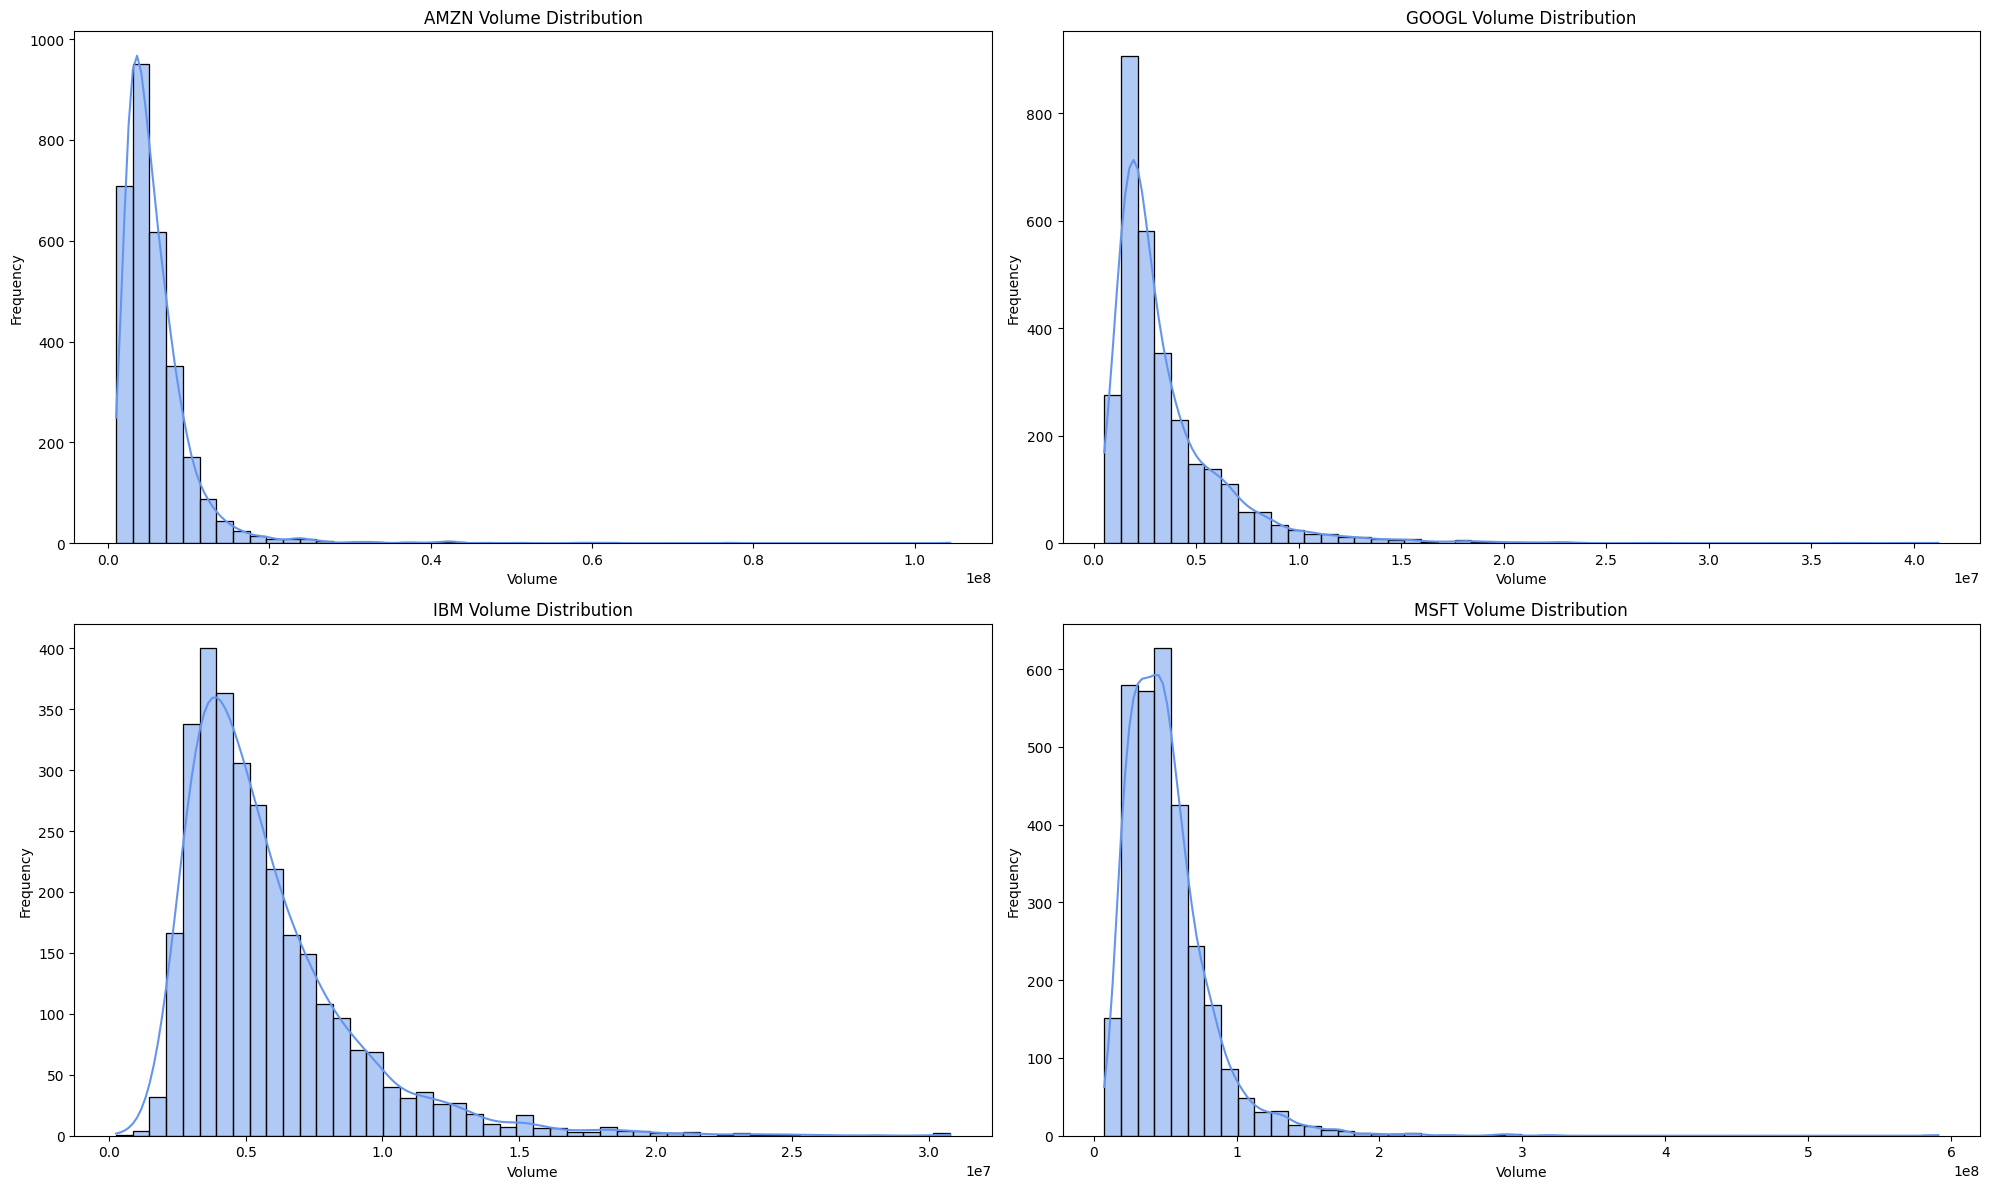

In [6]:
# Frequency distribution of volumes

plt.figure(figsize=(20, 12))

# List of stock names
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Plot histplot for volume distributions
for i, stock in enumerate(stock_names, 1):
    plt.subplot(2, 2, i)
    sns.histplot(combined_stock_df[f'{stock}_Volume'],
                 bins=50, 
                 kde=True,
                 color='cornflowerblue',
                 edgecolor='black')
    plt.title(f'{stock} Volume Distribution')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

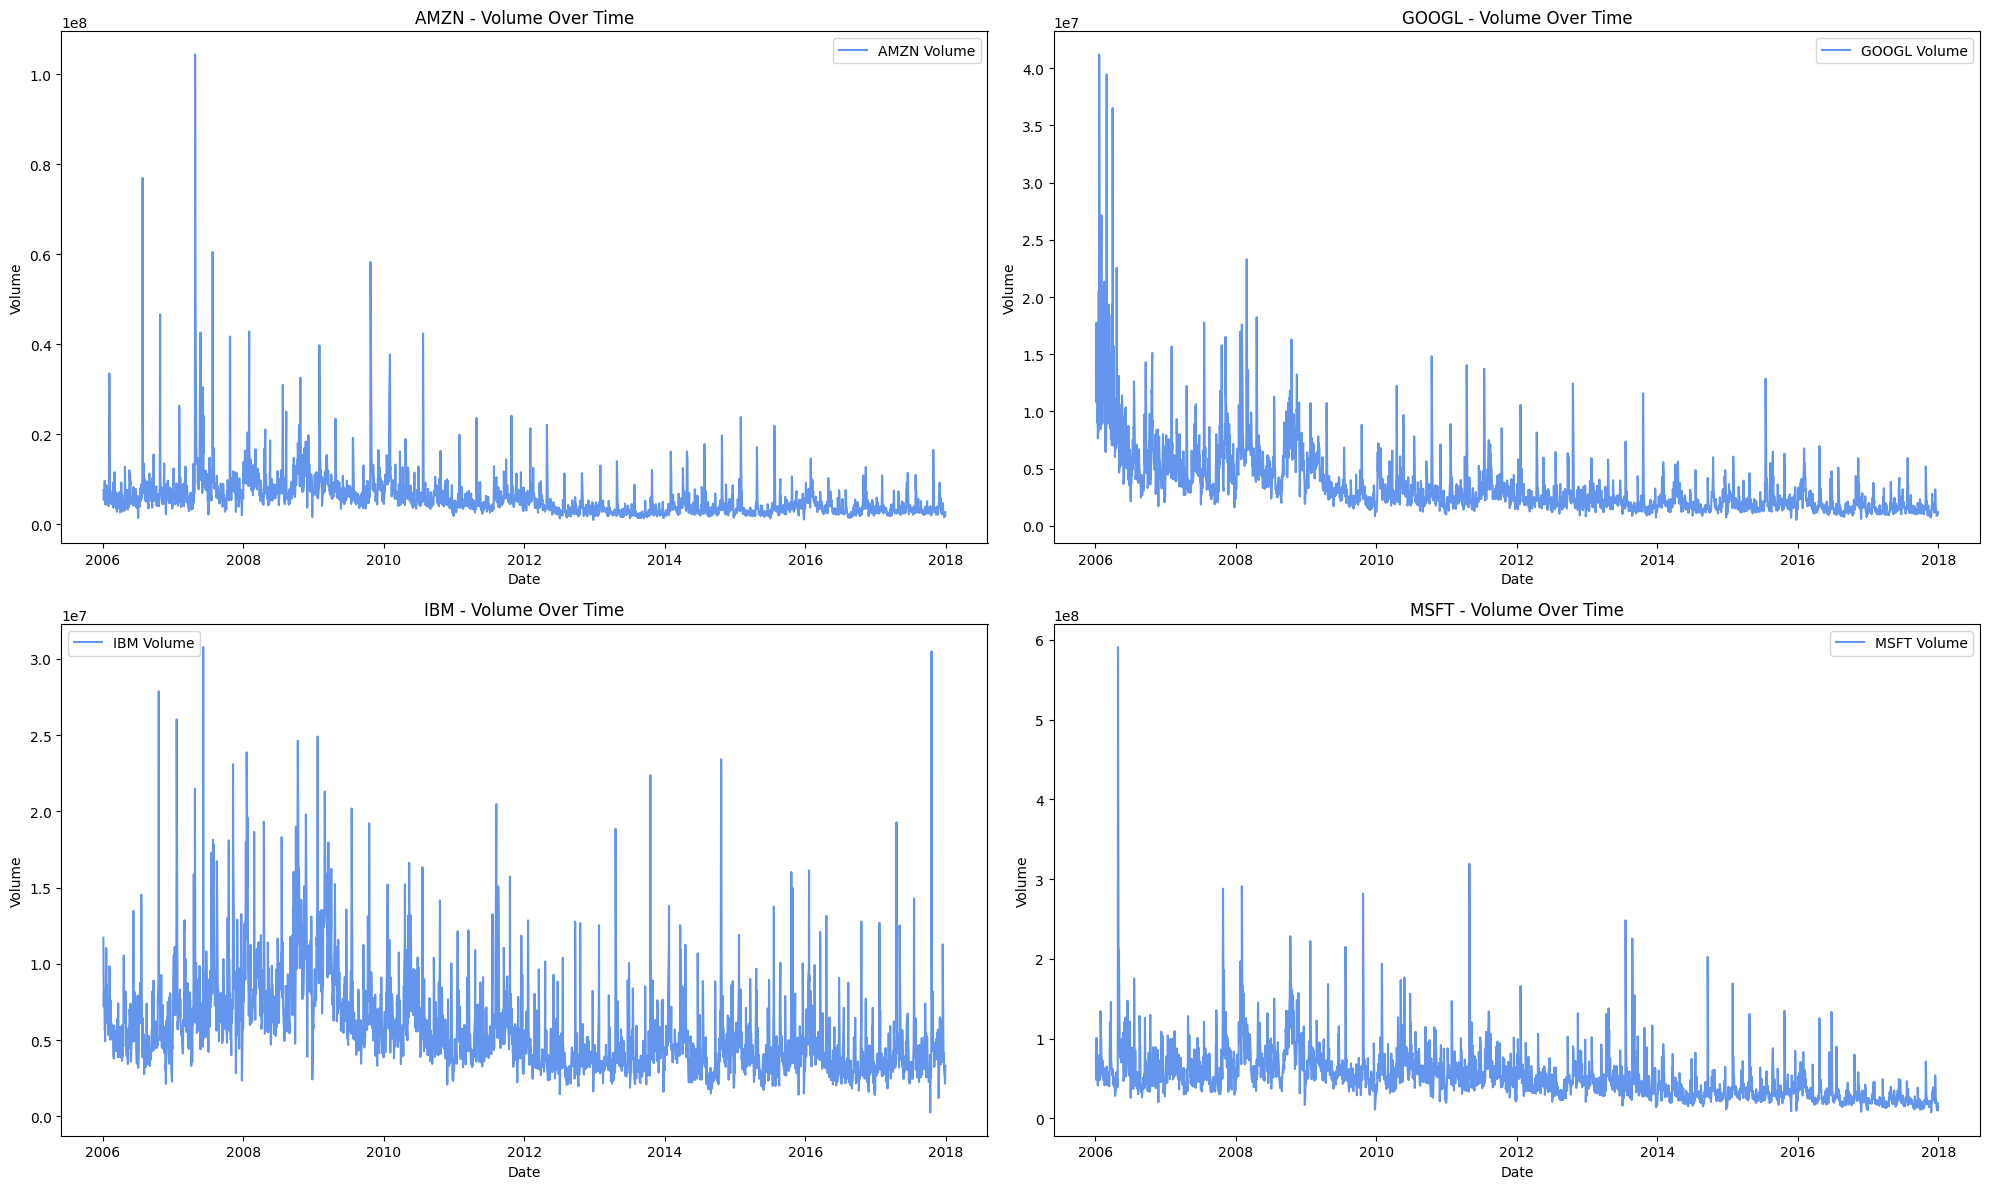

In [7]:
# Stock volume variation over time

plt.figure(figsize=(20, 12))

# Plot volume over time for each stock
for i, stock in enumerate(stock_names, 1):
    plt.subplot(2, 2, i)
    plt.plot(combined_stock_df['Date'], combined_stock_df[f'{stock}_Volume'], label=f'{stock} Volume', color='cornflowerblue')
    plt.title(f'{stock} - Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()

plt.tight_layout()
plt.show()

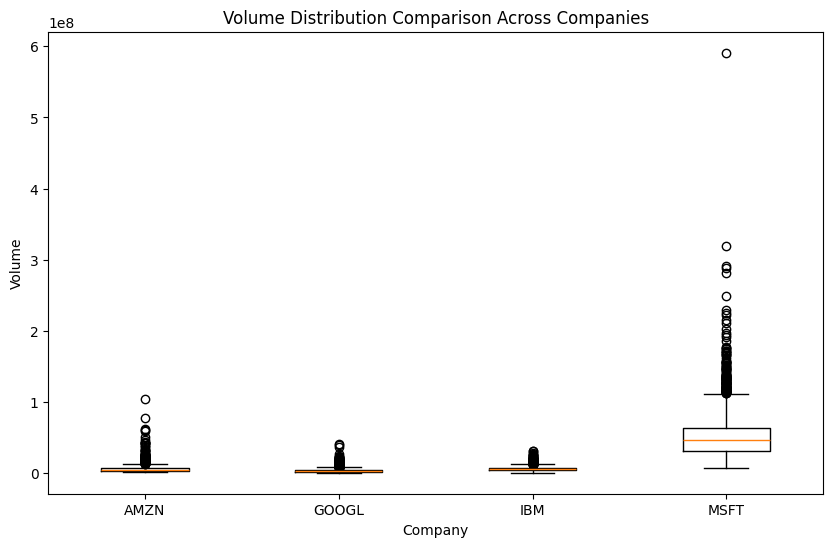

In [8]:
# Box plot to compare volume distributions across companies
plt.figure(figsize=(10, 6))
volume_data = [combined_stock_df[col] for col in ['AMZN_Volume', 'GOOGL_Volume', 'IBM_Volume', 'MSFT_Volume']]

plt.boxplot(volume_data, labels=stock_names)
plt.title('Volume Distribution Comparison Across Companies')
plt.xlabel('Company')
plt.ylabel('Volume')
plt.show()

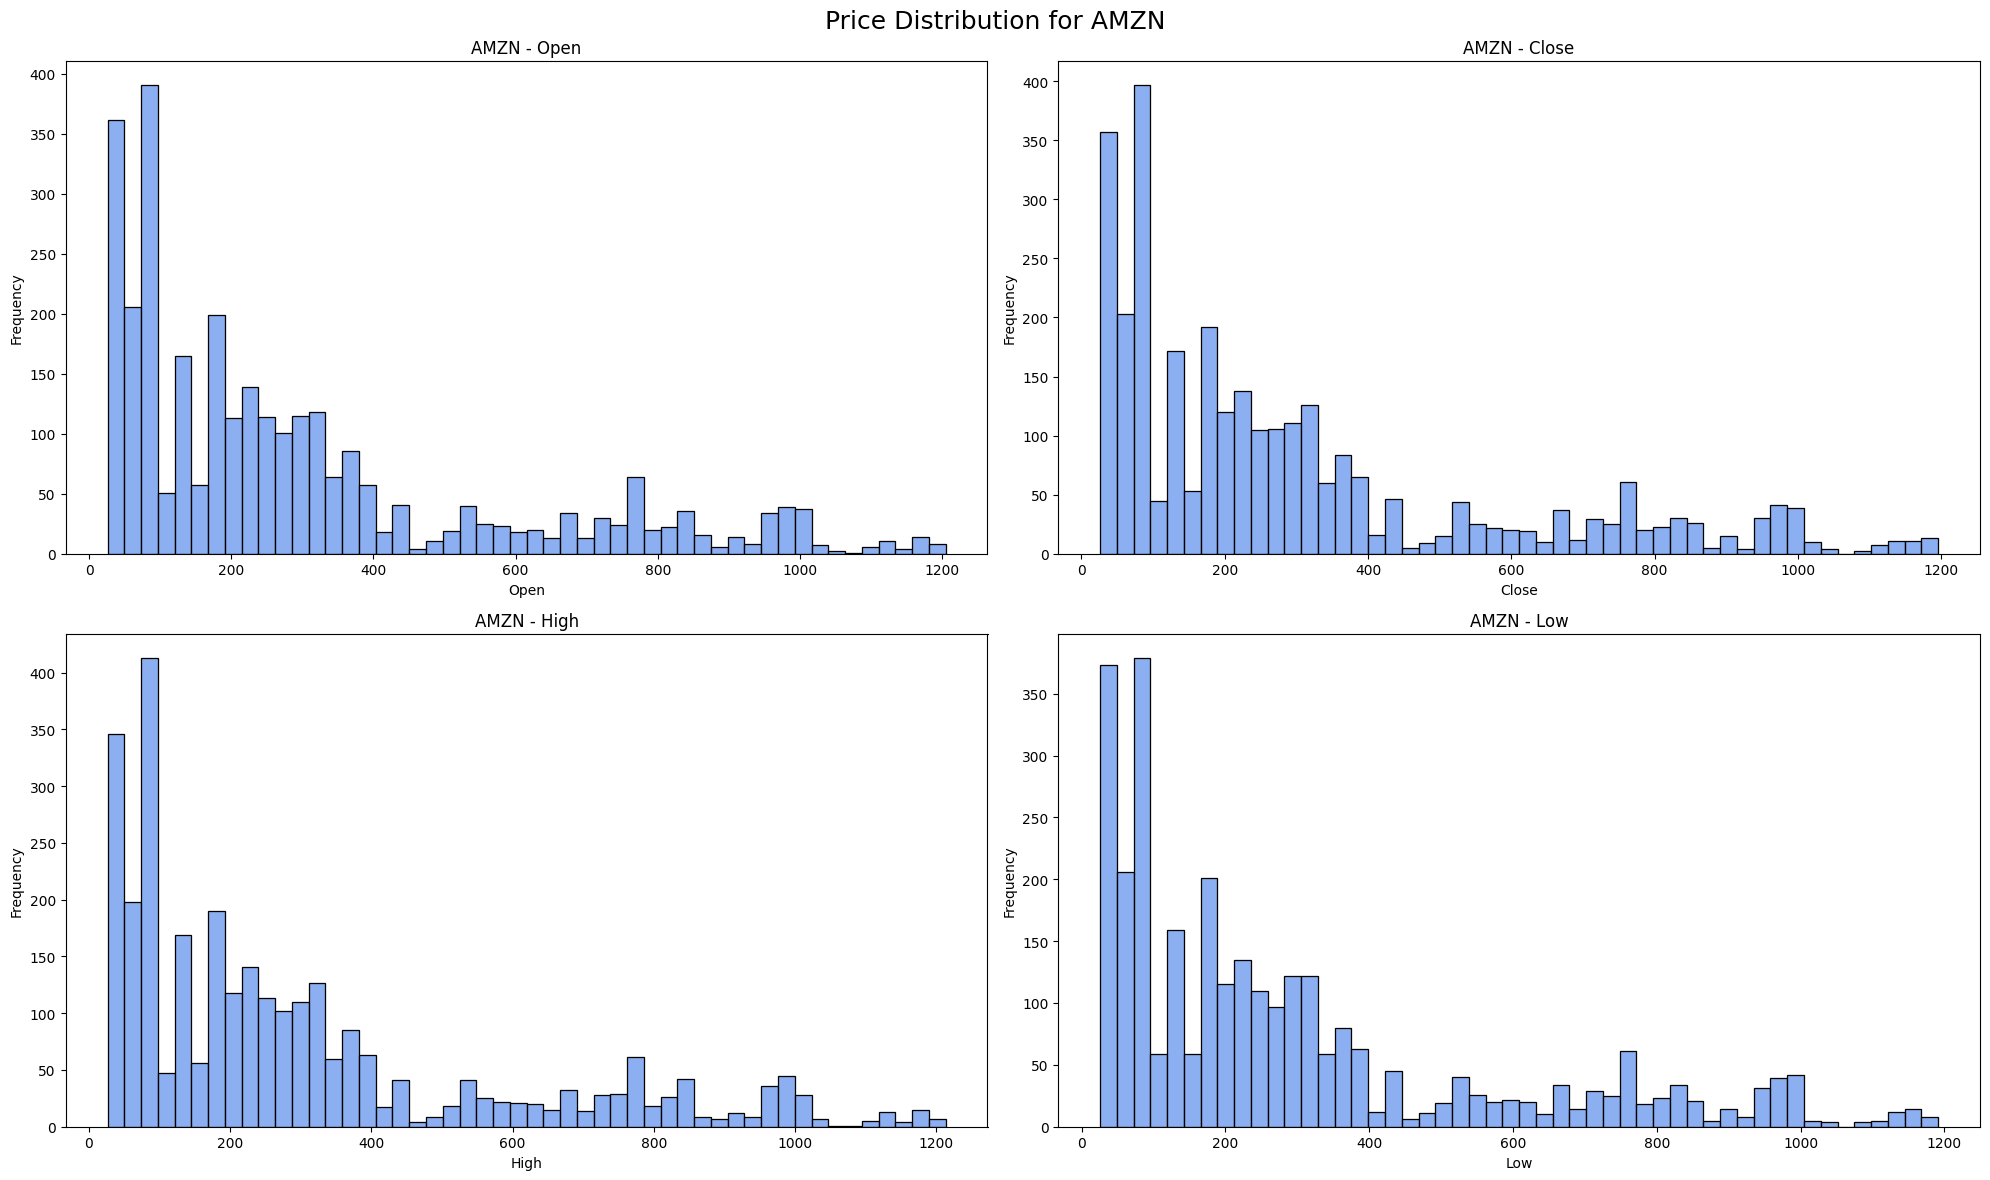

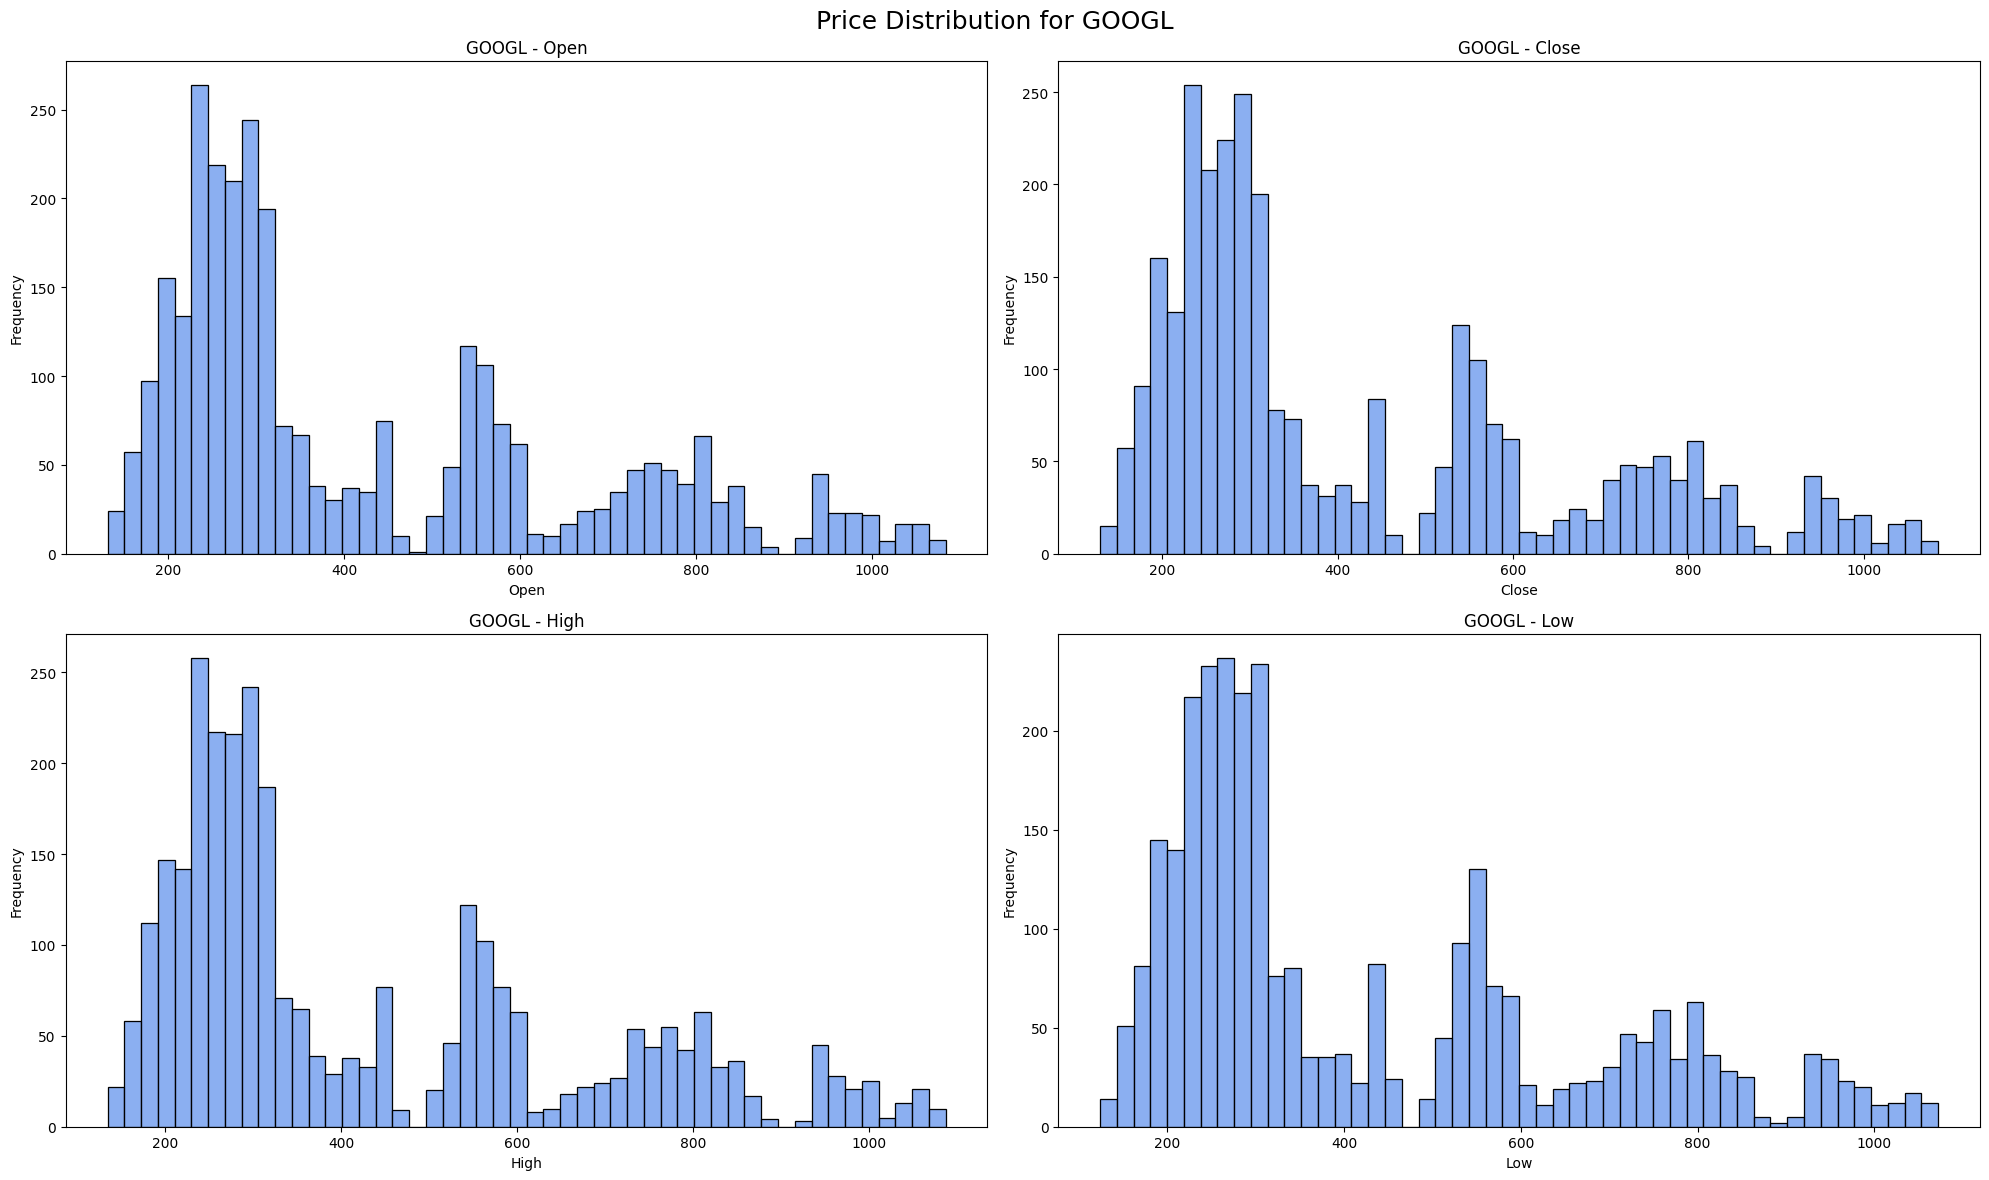

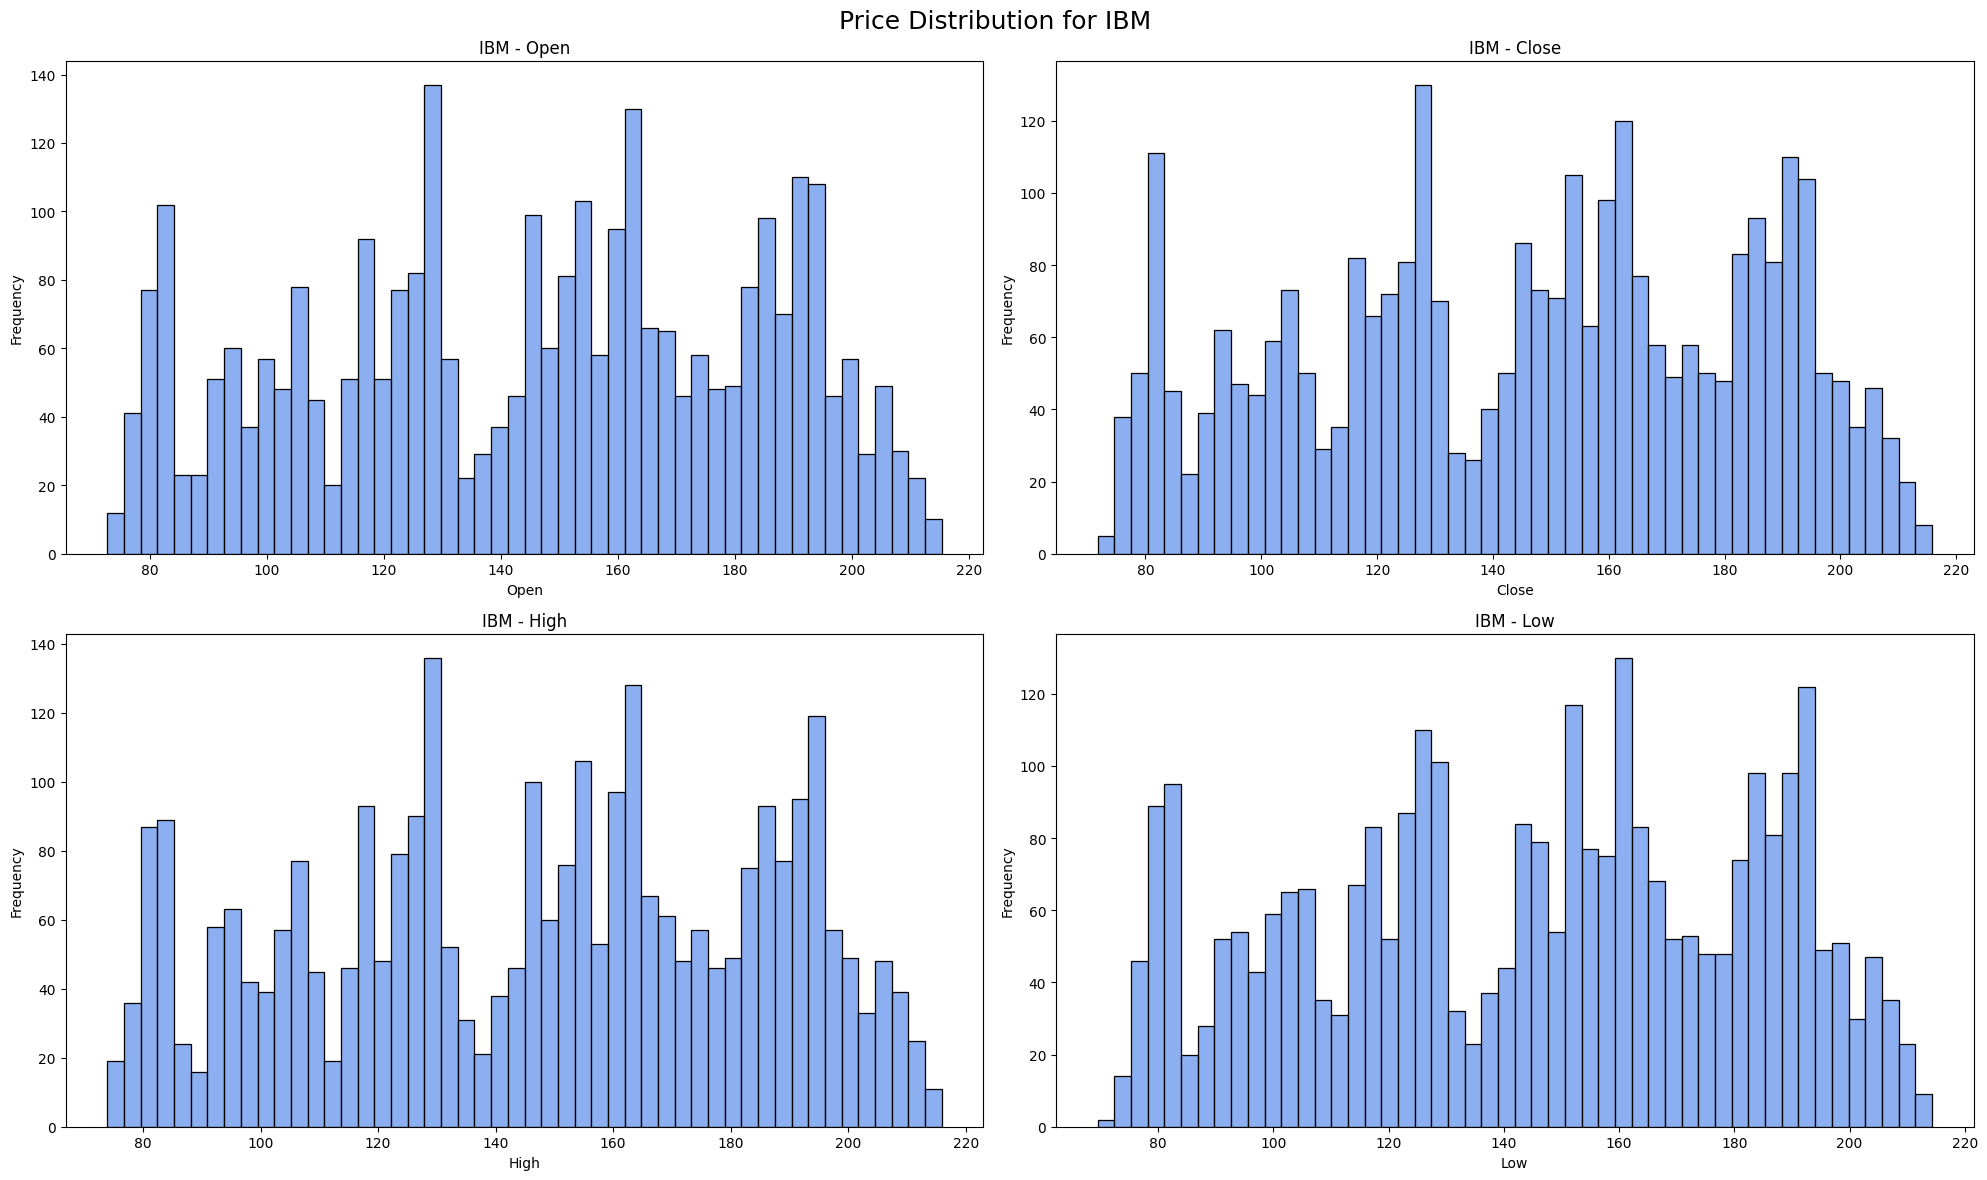

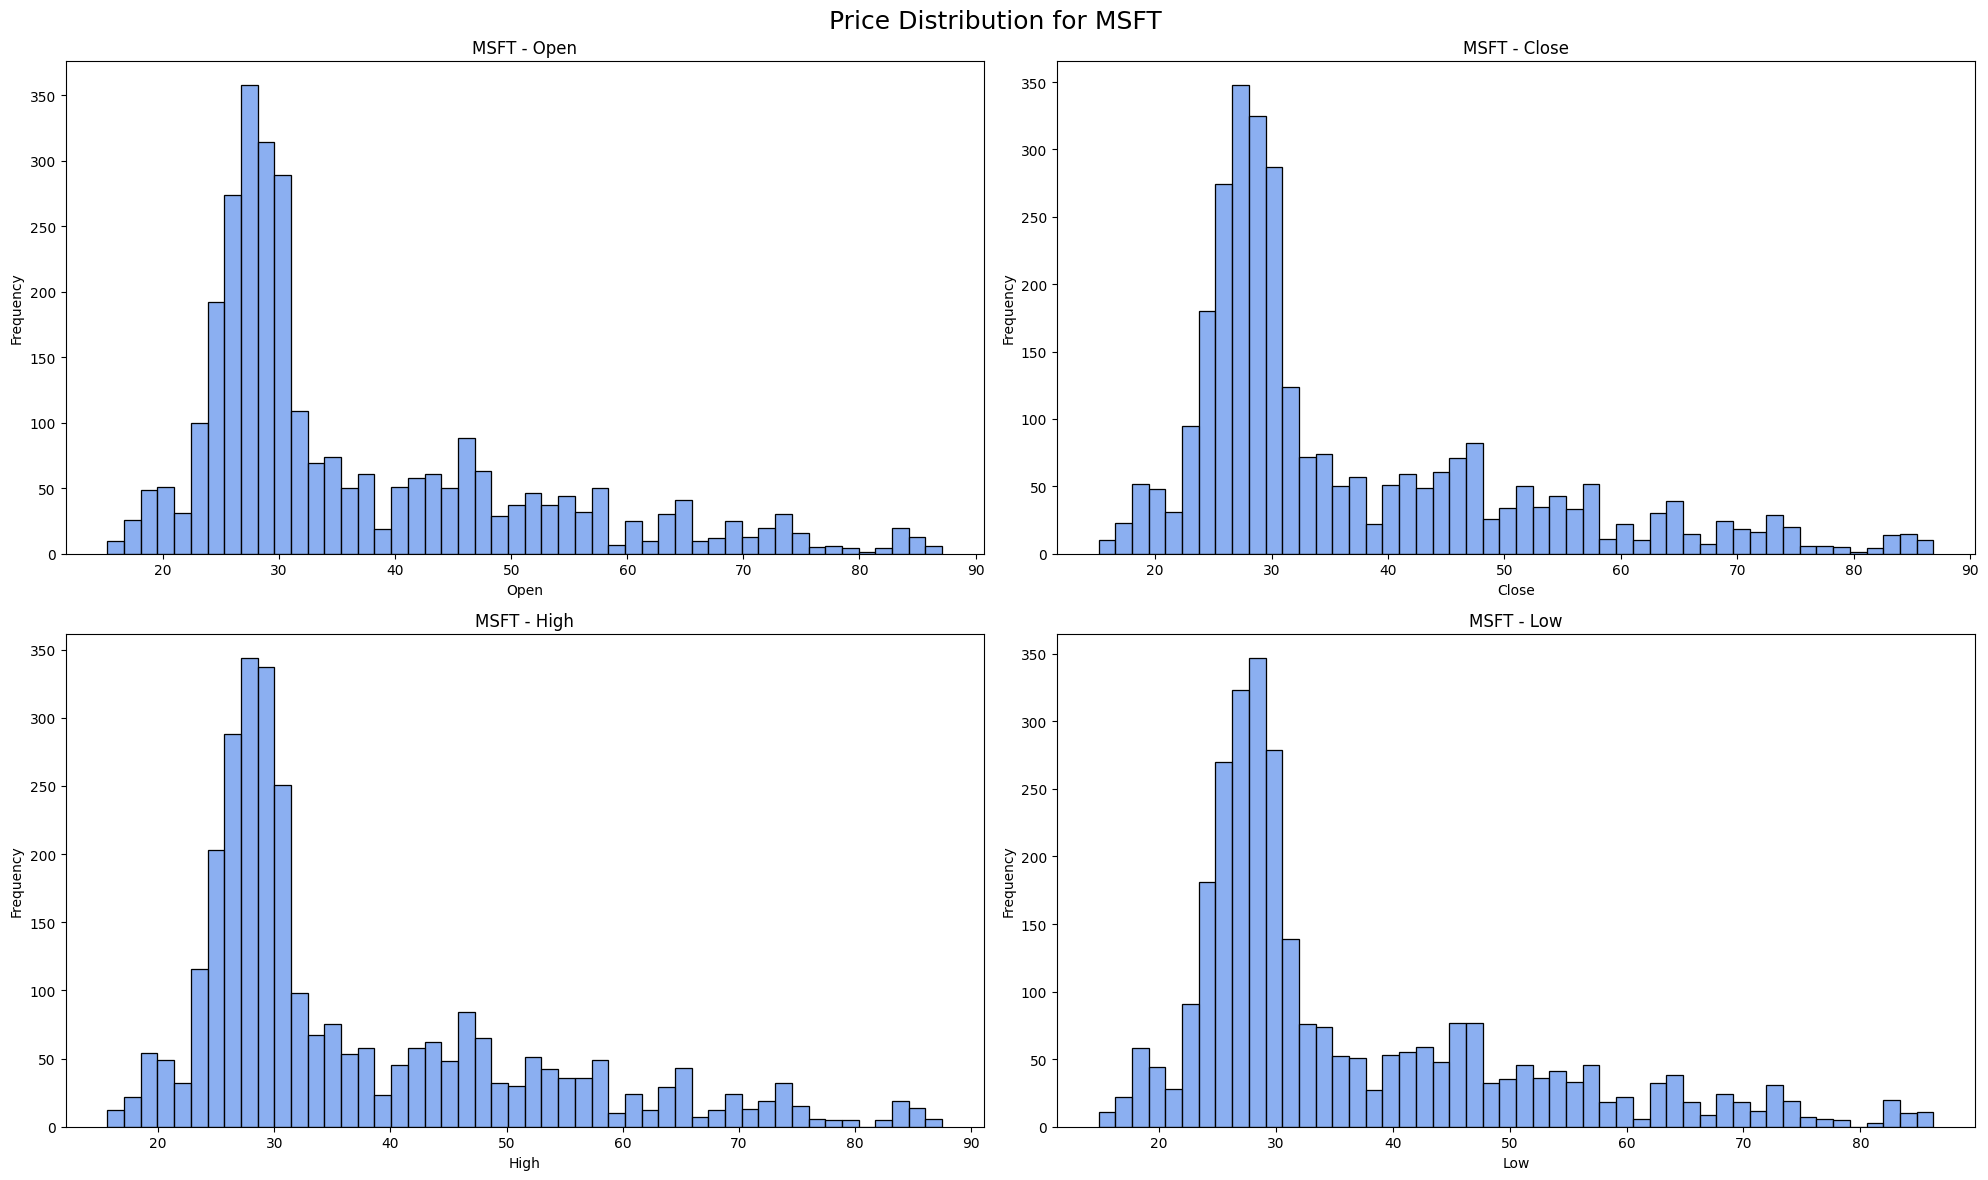

In [9]:
#Frequency Distribution for Different prices for different stocks

# Define price columns
price_columns = ['Open', 'Close', 'High', 'Low']

# Loop through each stock
for stock in stock_names:
    plt.figure(figsize=(20, 12))
    
    for i, col in enumerate(price_columns, 1):
        full_col_name = f'{stock}_{col}'
        
        plt.subplot(2, 2, i)
        sns.histplot(
            data=combined_stock_df,
            x=full_col_name,
            bins=50,
            kde=False,
            color='cornflowerblue',
            edgecolor='black'
        )
        plt.title(f'{stock} - {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
            
    plt.suptitle(f'Price Distribution for {stock}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

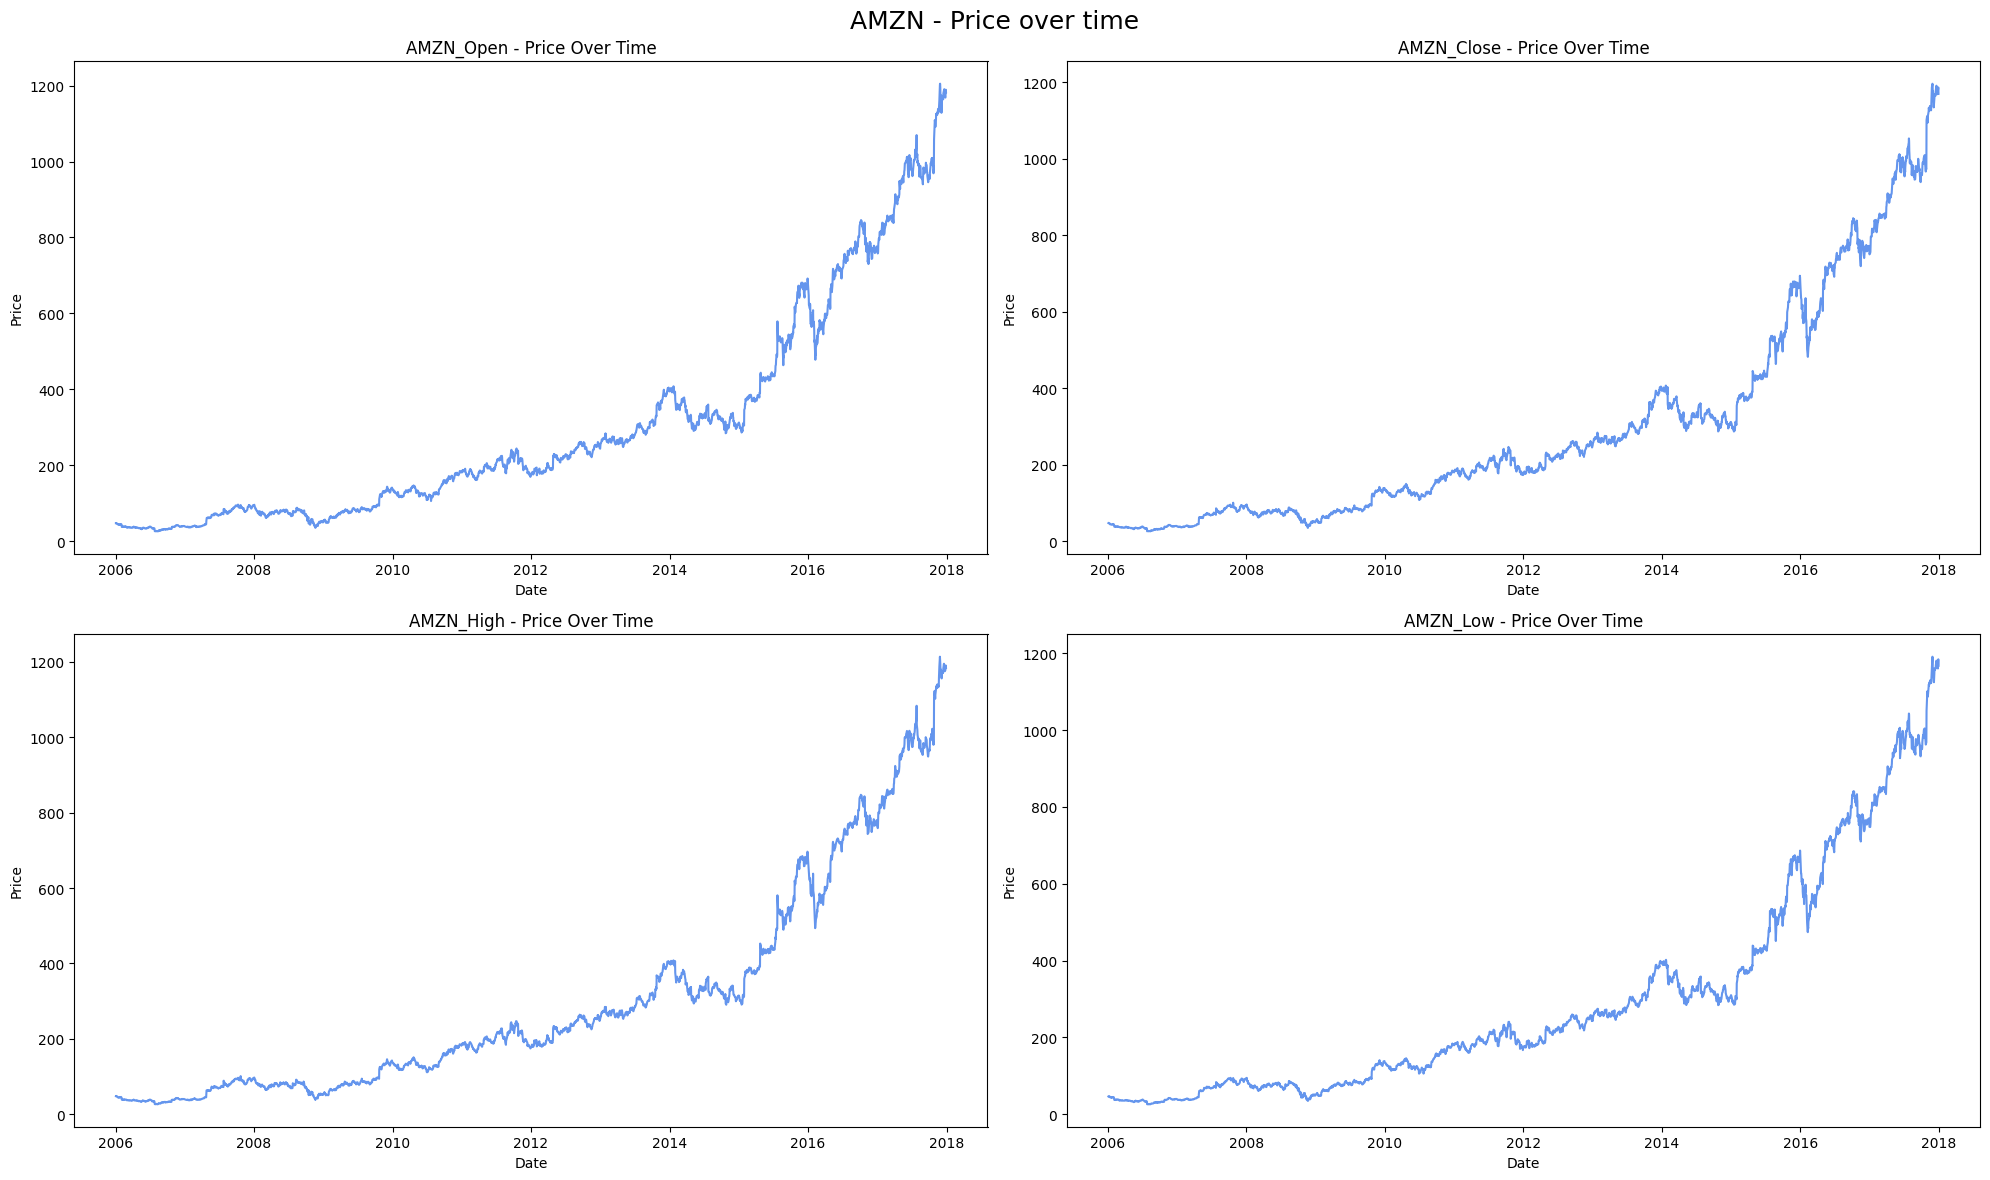

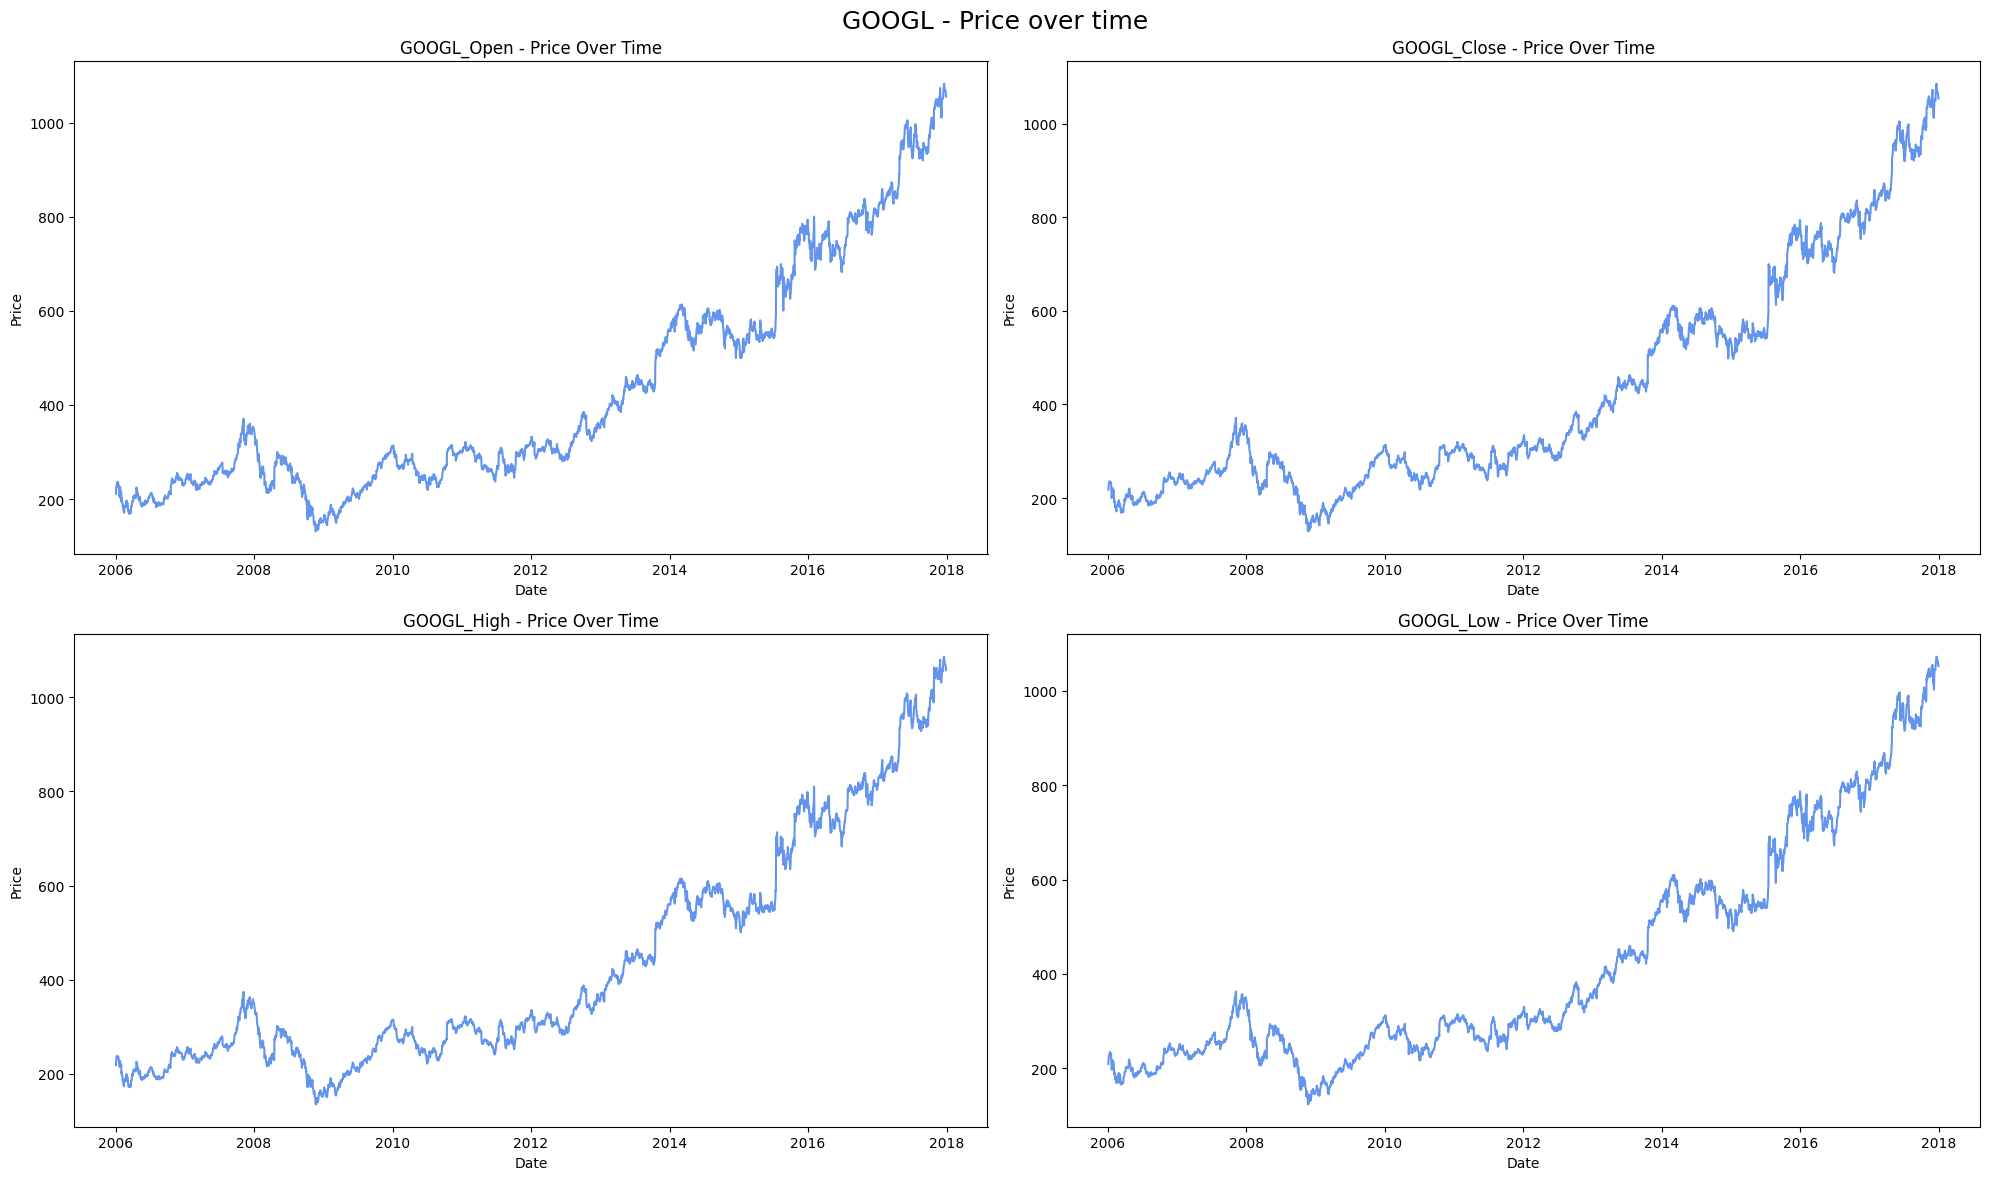

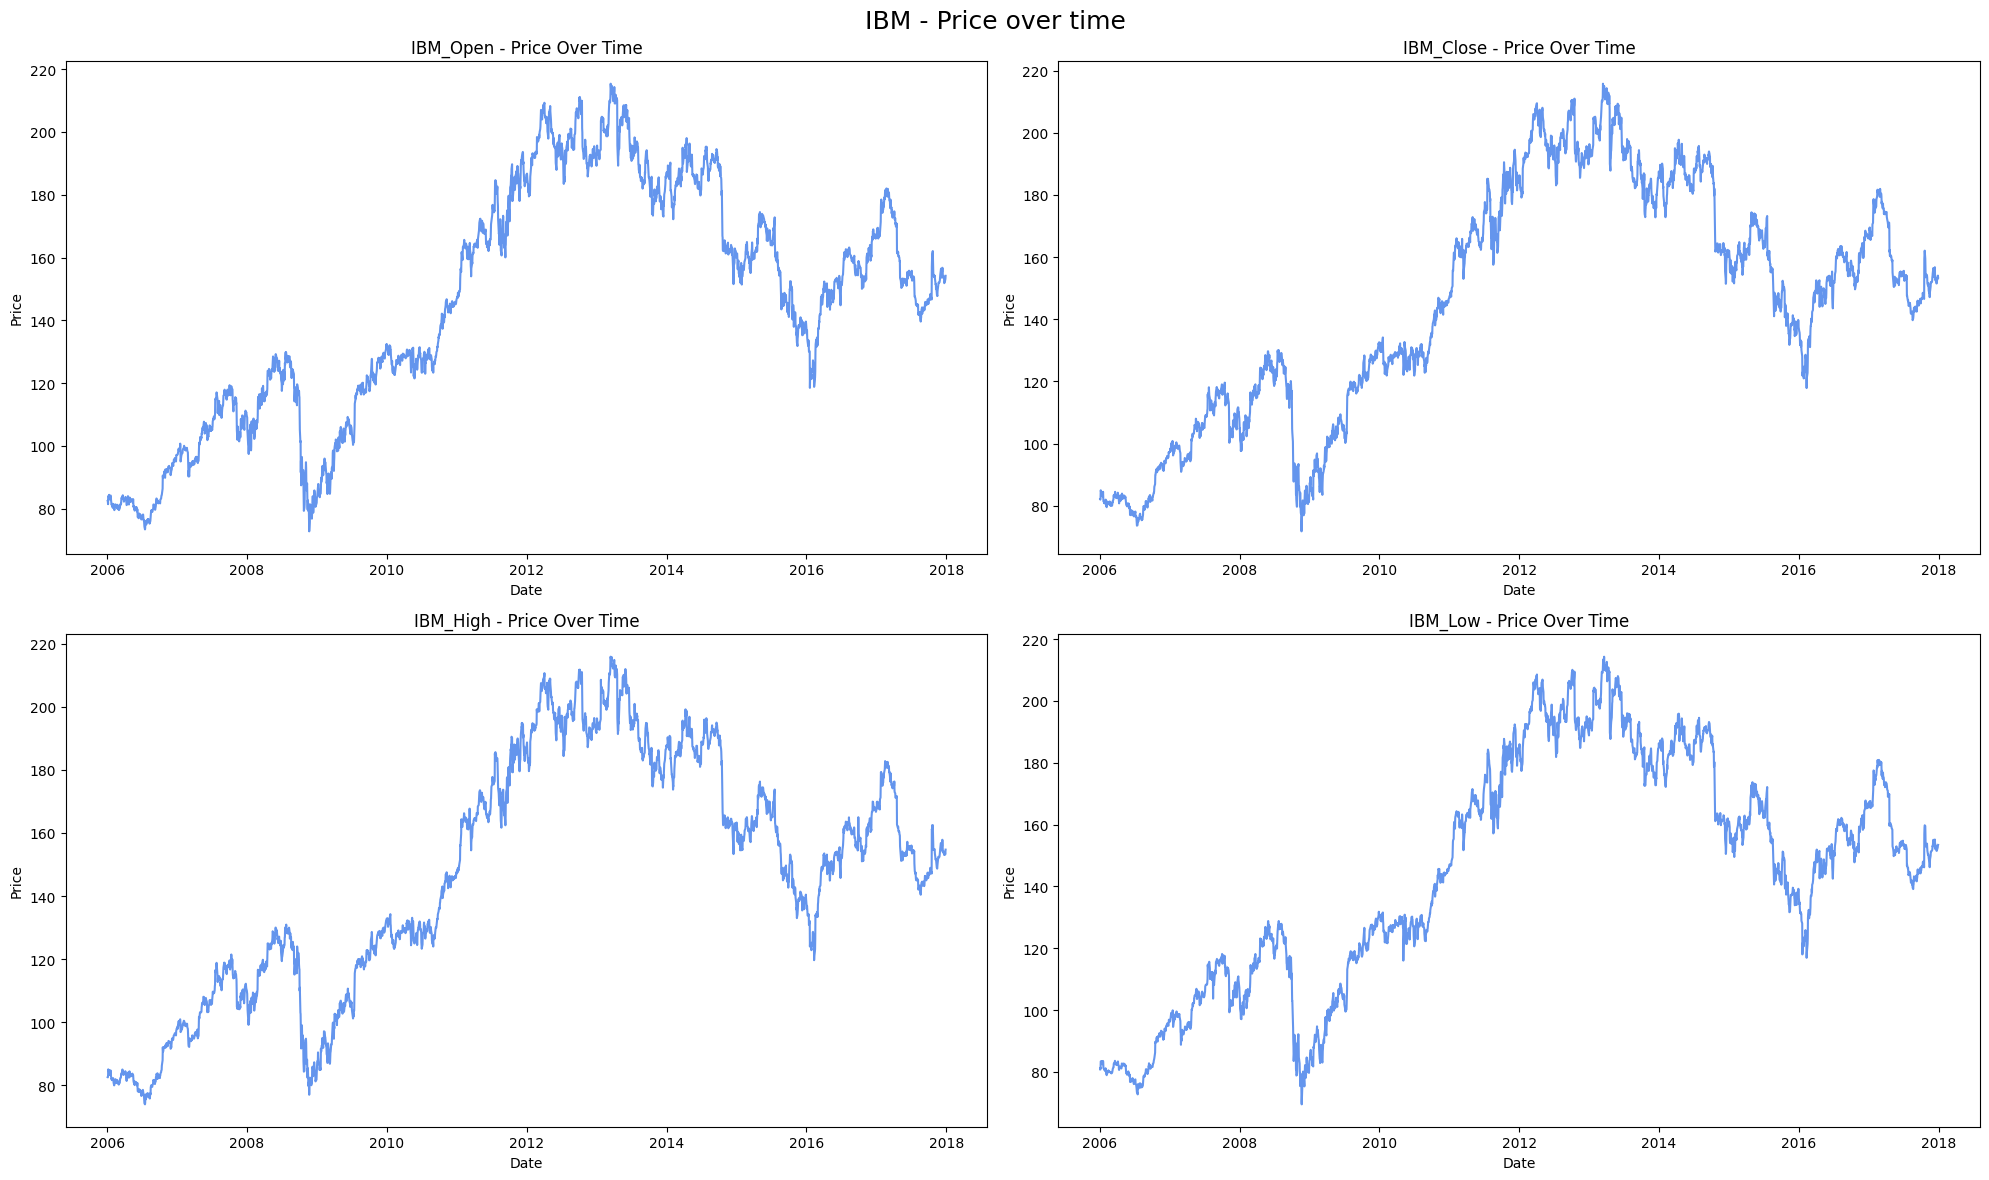

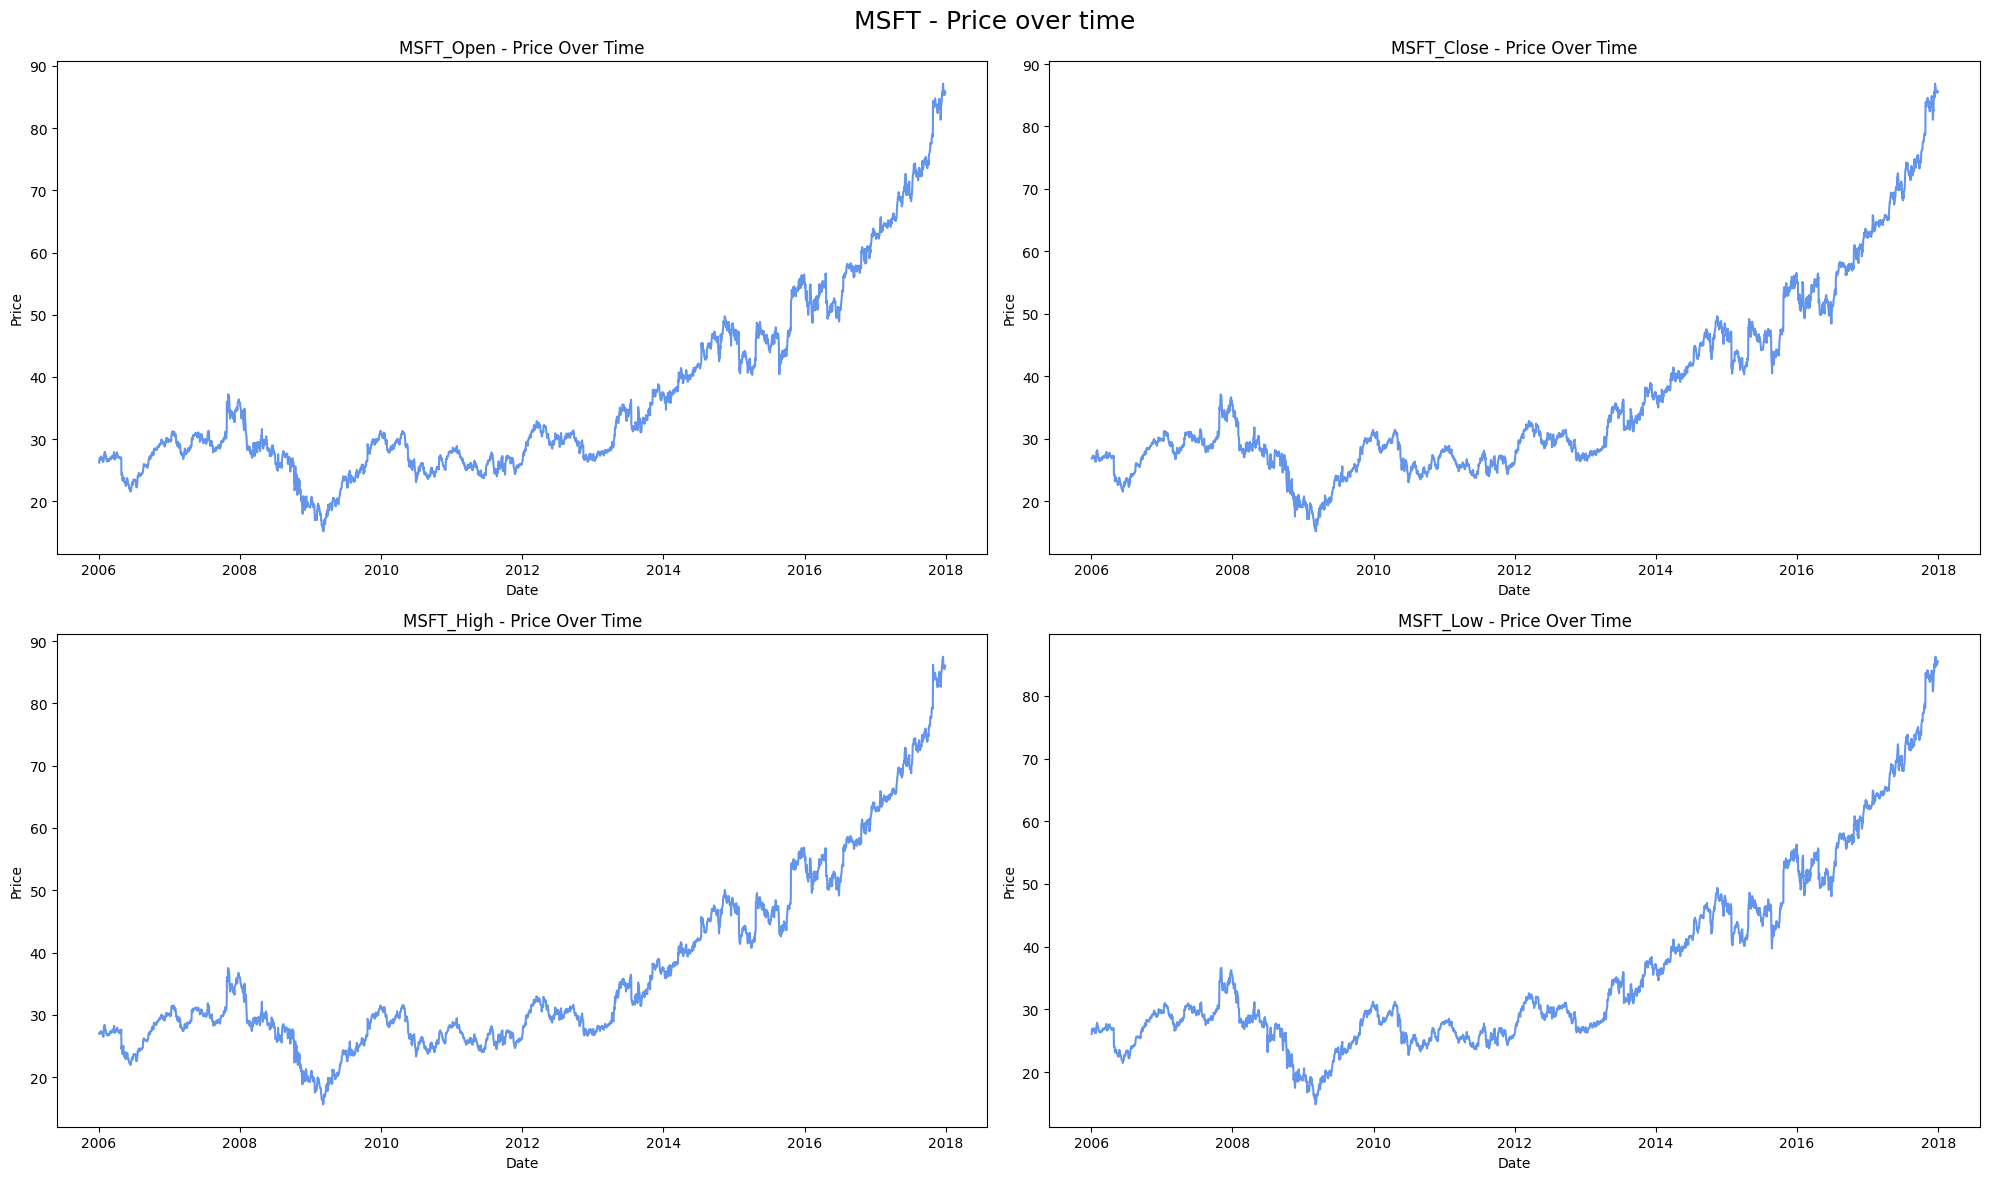

In [10]:
# # Define price columns
price_columns = ['Open', 'Close', 'High', 'Low']

# Loop through each stock
for stock in stock_names:
    plt.figure(figsize=(20, 12))
    
    for i, col in enumerate(price_columns, 1):
        full_col_name = f'{stock}_{col}'
        
        plt.subplot(2, 2, i)
        plt.plot(combined_stock_df['Date'], combined_stock_df[full_col_name], color='cornflowerblue')
        plt.title(f'{full_col_name} - Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
            
    plt.suptitle(f'{stock} - Price over time', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

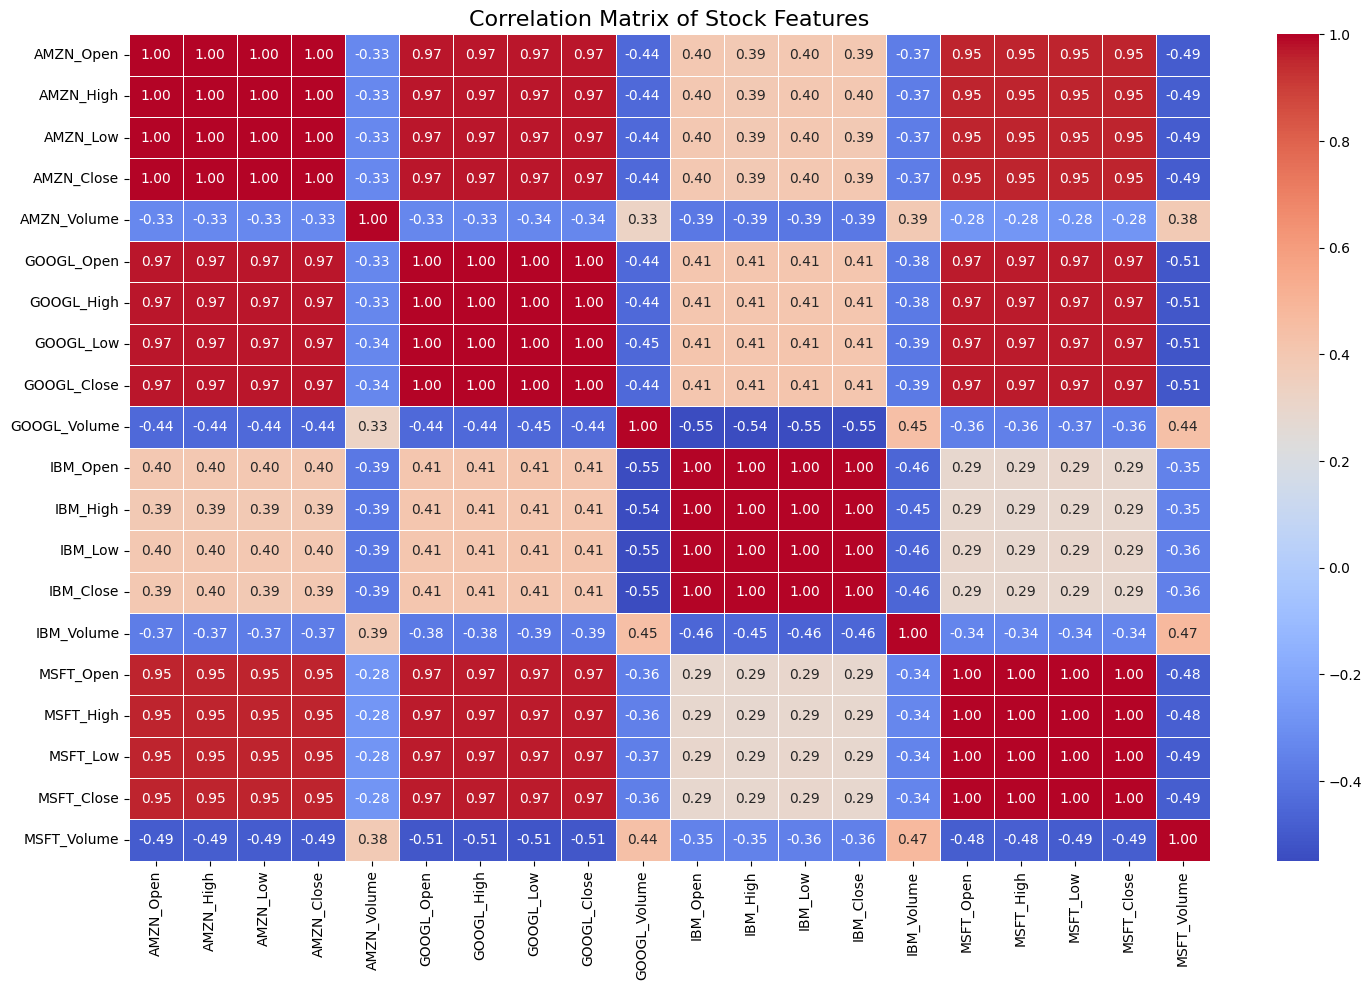

In [11]:
# Analyse correlations

# Drop the Date column for correlation analysis
corr_data = combined_stock_df.drop(columns=['Date'])

# Compute the correlation matrix
corr_matrix = corr_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Matrix of Stock Features', fontsize=16)
plt.tight_layout()
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [12]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(data, window_size=3, window_stride=1, target_names=None):
    """
	Create windowed data for RNN training.
	
	Parameters:
	data (pandas.DataFrame): The input dataframe containing all features
    window_size (int): Size of the sliding window
    window_stride (int): Step size for sliding the window
	target_names (list): List of target column names to predict
	
	Returns:
	tuple: (X_windowed, y_windowed) where:
		   X_windowed is a numpy array of shape (n_samples, window_size, n_features)
		   y_windowed is a numpy array of shape (n_samples, n_targets)
	"""
    # Drop Date column if it exists
    if 'Date' in data.columns:
        data = data.drop(columns=['Date'])

    data_values = data.values
    num_rows = data_values.shape[0]
    num_features = data_values.shape[1]
    
    X_windowed, y_windowed = [], []

    for start in range(0, num_rows - window_size, window_stride):
        end = start + window_size
        if end >= num_rows:
            break
        X_window = data_values[start:end, :]
        y_target = data.loc[end, target_names].values
        X_windowed.append(X_window)
        y_windowed.append(y_target)

    return np.array(X_windowed), np.array(y_windowed)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [13]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X,y):
    """
    Scales the windowed input features and target data.
    
    Parameters:
    - X: Input data of shape (num_samples, window_size, num_features).
    - y: Target data of shape (num_windows, num_targets).
   
    Returns:
    - X_scaled: 3D array (samples, window_size, features)
    - y_scaled: 2D array (samples, features)
    - scaler: StandardScaler object (fitted on past windows)
    """
    num_samples, window_size, num_features = X.shape

    # Initialize scaler
    scaler = StandardScaler()

    # Incrementally fit scaler on each window (reshape to 2D)
    for i in range(num_samples):
        window_2d = X[i].reshape(-1, num_features)  # shape: (window_size, num_features)
        scaler.partial_fit(window_2d)

    # Scale each window of X
    X_scaled = np.empty_like(X)
    for i in range(num_samples):
        window_2d = X[i].reshape(-1, num_features)
        window_scaled = scaler.transform(window_2d)
        X_scaled[i] = window_scaled.reshape(window_size, num_features)

    # Scale y
    y_scaled = scaler.fit_transform(y)

    return np.array(X_scaled), np.array(y_scaled), scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [14]:
# Define a function to create input and output data points from the master DataFrame

def prepare_rnn_data(master_data, target_names, window_size=3, window_stride=1, train_ratio=0.8):
    """
	Create windowed data and split into training and validation sets.
	
	Parameters:
	master_data (pandas.DataFrame): The input dataframe containing all features
	target_names (list): List of target column names to predict
	window_size (int): Size of the sliding window
	window_stride (int): Step size for sliding the window
	train_ratio (float): Proportion of data to use for training
	
	Returns:
	tuple: (X_train, X_test, y_train, y_test) windowed and split data
	"""
    # 1. Create windows of X and y
    X, y = create_windowed_data(master_data, window_size, window_stride, target_names)

    # 2. Scale X using incremental scaler
    X_scaled, y_scaled, scaler = scale_windowed_data(X, y)

    #3. Train-test split (shuffle=False for time series data)
    split_index = int(len(X_scaled) * train_ratio)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

    return X_train, y_train, X_test, y_test, scaler



In [15]:
target_cols = ['AMZN_Close']  # or multiple targets like ['AMZN_Close', 'GOOGL_Close']
window_size = 3
window_stride = 1
train_ratio = 0.8

X_train, y_train, X_test, y_test, scaler_X = prepare_rnn_data(
    combined_stock_df,
    target_names=target_cols,
    window_size=window_size,
    window_stride=window_stride,
    train_ratio=train_ratio
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2413, 3, 20)
y_train shape: (2413, 1)
X_test shape: (604, 3, 20)
y_test shape: (604, 1)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

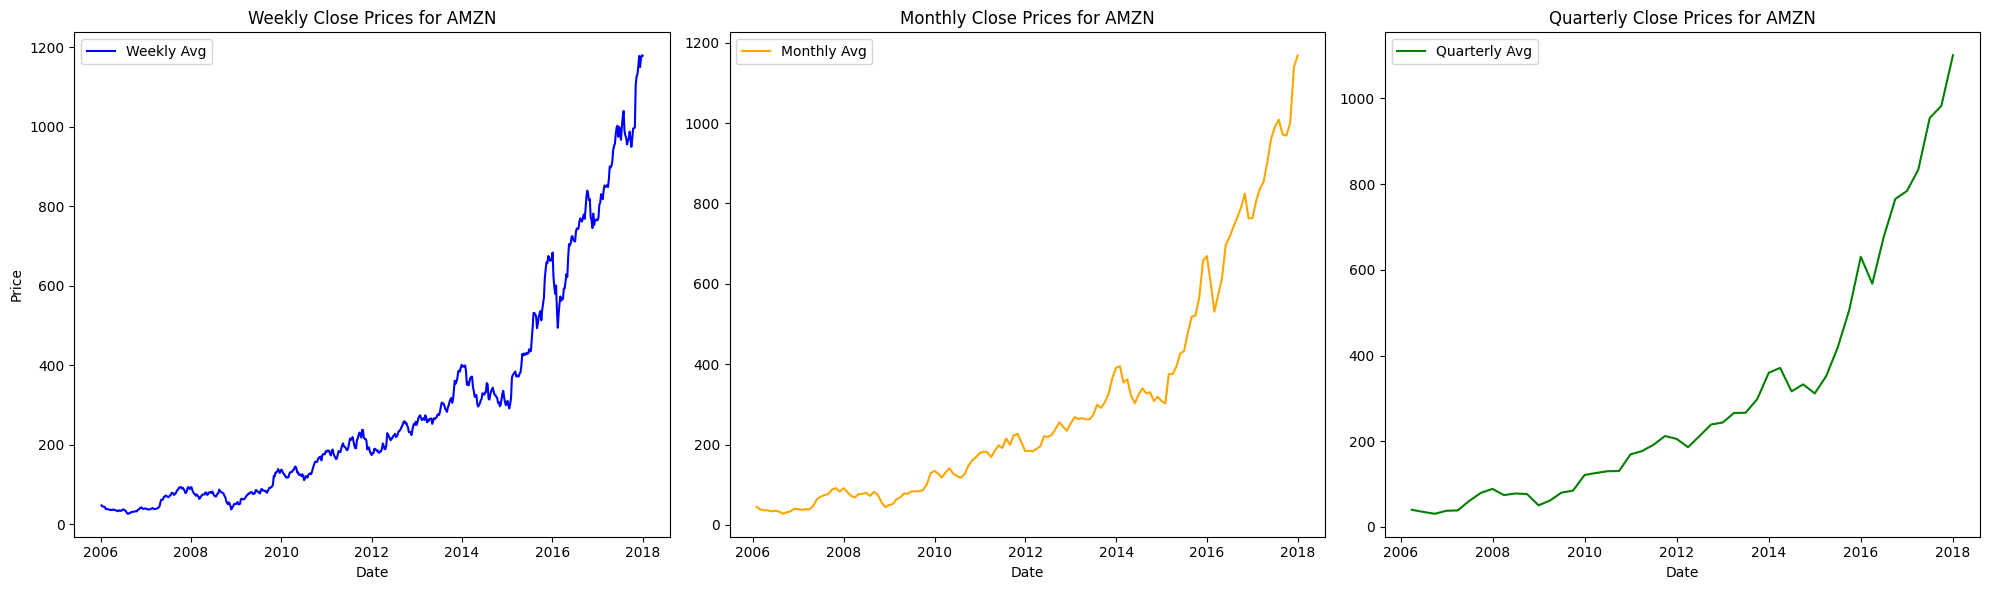

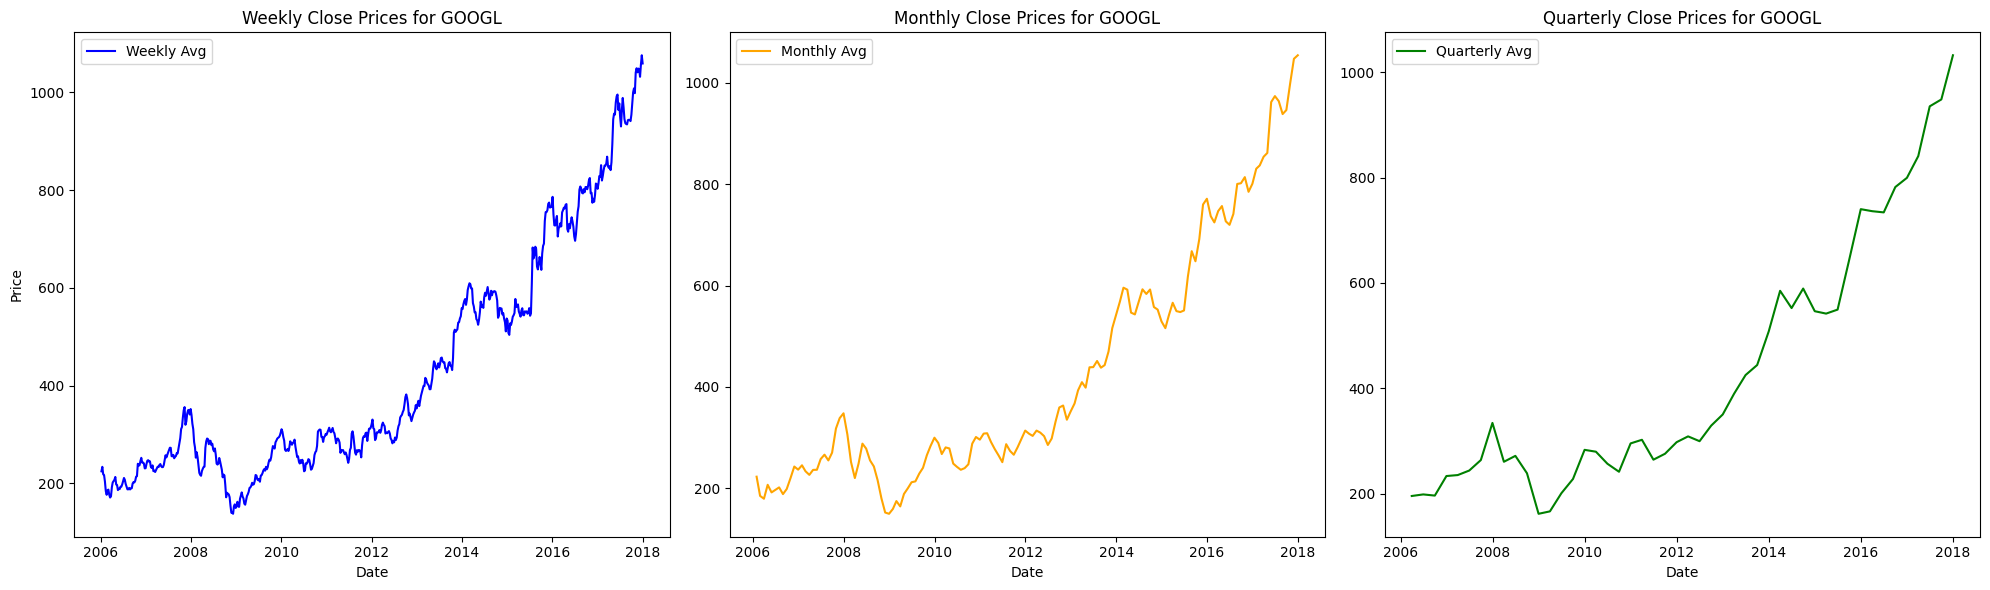

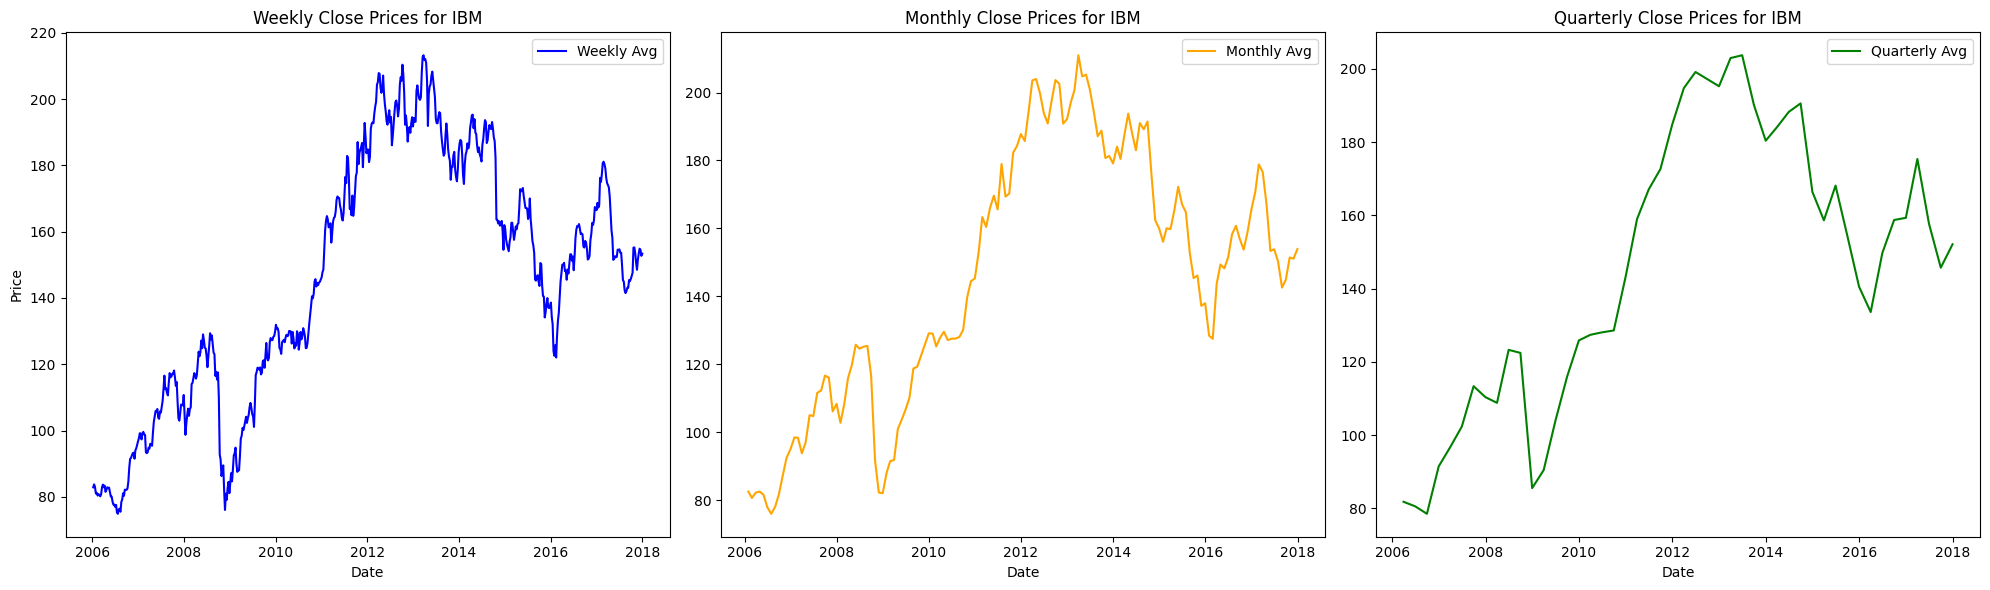

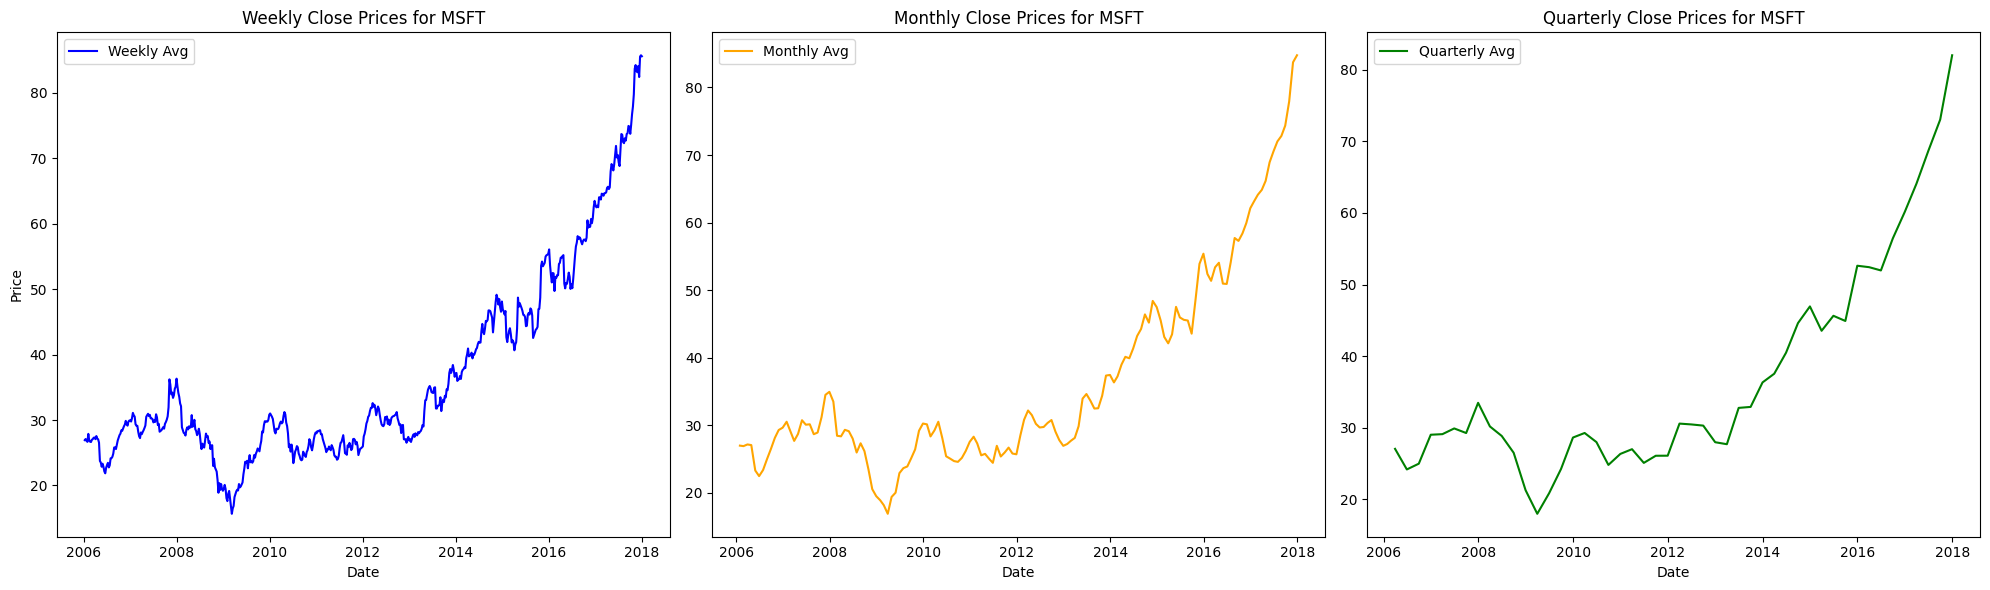

In [16]:
# Plotting function for a given stock name for various intervals
def plot_graphs(stock_name, weekly, monthly, quarterly):
    
    plt.figure(figsize=(20,6))

    # Plot for Weekly Close Price
    plt.subplot(1, 3, 1)
    plt.plot(weekly, label='Weekly Avg', color='blue')
    plt.title(f'Weekly Close Prices for {stock_name}')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()

    # Plot for Monthly Close Price
    plt.subplot(1, 3, 2)
    plt.plot(monthly, label='Monthly Avg', color='orange')
    plt.title(f'Monthly Close Prices for {stock_name}')
    plt.xlabel("Date")
    plt.legend()

    # Plot for Quarterly Close Price
    plt.subplot(1, 3, 3)
    plt.plot(quarterly, label='Quarterly Avg', color='green')
    plt.title(f'Quarterly Close Prices for {stock_name}')
    plt.xlabel("Date")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
# Resample Close prices for all 4 stocks by different intervals

# Identify all Close price columns
close_cols = [col for col in combined_stock_df.columns if 'Close' in col]

# Ensure 'Date' is datetime type and set as index
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'])
combined_stock_df.set_index('Date', inplace=True)

for col in close_cols:    
    # Weekly average
    weekly = combined_stock_df[col].resample('W').mean()
    # Monthly average
    monthly = combined_stock_df[col].resample('M').mean()
    # Quarterly average
    quarterly = combined_stock_df[col].resample('Q').mean()
    # Plot the graphs for above 3 intervals 
    plot_graphs(col.split('_')[0], weekly, monthly, quarterly)

# Reset index if needed for further processing
combined_stock_df.reset_index(inplace=True)

> <span style="color: blue;">As weekly, monthly, and quarterly plots of stock’s closing price are similar in trend across timeframes which suggests:</span>
>
> <span style="color: blue;">- There's no strong seasonality or cyclic behavior that depends on shorter or longer time units.
> 
> <span style="color: blue;">- The data is trend-driven, not time-unit driven.
> 
> <span style="color: blue;">In such case, we can choose a moderate window size(30 business days - 1 month) that balances:
>
> <span style="color: blue;">- Capturing enough historical context
> 
> <span style="color: blue;">- Not being too long to overfit or dilute recent trends

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [17]:
# Create data instances from the master data frame using decided window size and window stride

target_cols = ['AMZN_Close'] 
window_size = 30
window_stride = 1
train_ratio = 0.8

X_train, y_train, X_test, y_test, scaler_X = prepare_rnn_data(
    combined_stock_df,
    target_names=target_cols,
    window_size=window_size,
    window_stride=window_stride,
    train_ratio=train_ratio
)


In [18]:
# Check the number of data points generated
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

num_samples = X_train.shape[0] + X_test.shape[0]
print(f"Total number of windowed data points generated: {num_samples}")

X_train shape: (2392, 30, 20)
y_train shape: (2392, 1)
X_test shape: (598, 30, 20)
y_test shape: (598, 1)
Total number of windowed data points generated: 2990


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [19]:
# Check if the datasets are compatible inputs to neural networks
print("\033[1mChecking dataset shapes for neural network compatibility:\033[0m")

# Data Type: Must be numeric arrays
print("\nData Type of X_train:", type(X_train))
print("Data Type of y_train:", type(y_train))

# Input Shape: Must match RNN expectations — typically (samples, timesteps, features)
print("\nX_train shape:", X_train.shape)  # Expected: (num_samples, window_size, num_features)
print("y_train shape:", y_train.shape)  # Expected: (num_samples, num_targets)

# No Missing Values
print("\nAny NaNs in X_train?", np.isnan(X_train).any())
print("Any NaNs in y_train?", np.isnan(y_train).any())
print("Any Infs in X_train?", np.isinf(X_train).any())
print("Any Infs in y_train?", np.isinf(y_train).any())

#Consistent Sample Count Between X and y
assert X_train.shape[0] == y_train.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in number of testing samples"

# Scaled Inputs (Have a mean ~0 and std ~1 (StandardScaler))
print("\nX_train mean:", X_train.mean())
print("X_train standard deviation:", X_train.std())

Checking dataset shapes for neural network compatibility:

Data Type of X_train: <class 'numpy.ndarray'>
Data Type of y_train: <class 'numpy.ndarray'>

X_train shape: (2392, 30, 20)
y_train shape: (2392, 1)

Any NaNs in X_train? False
Any NaNs in y_train? False
Any Infs in X_train? False
Any Infs in y_train? False

X_train mean: -0.23799576426049535
X_train standard deviation: 0.8135546936994348


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [20]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn(units, activation, input_shape, dropout_rate, target_len, learning_rate):
    """
    Create a simple RNN model.

    Parameters:
    - units (int): number of units in the RNN layer
    - activation (str): Activation function for RNN layer
    - input_shape (tuple): shape of input (timesteps, features)
    - dropout_rate (float): dropout rate (0 to 1)
    - target_len (int): number of outputs (e.g. 4 for 4 stocks)
    - learning_rate (float): Learning rate for optimizer

    Returns:
    - Compiled Keras model
    """
    # Initialize the model
    model = Sequential()
    
    # Add the Simple RNN layer
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape, return_sequences=False))
    
    # Add dropout for regularization
    model.add(Dropout(dropout_rate))
   
    # Add a Dense output layer 
    model.add(Dense(target_len))
    
    # Compile the model with Adam optimizer and MSE loss function 
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [21]:
# Find an optimal configuration of simple RNN

# Initialise list of configurations
units_list = [32, 64, 128]
dropout_rates = [0.1, 0.2]
learning_rate_options = [0.001, 0.0005]
activation_list = ['tanh', 'relu']
input_shape = X_train.shape[1:]
target_len =  y_train.shape[1]
results = []

# Initialise early stopping
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)

# Iterate through each set of hyperparameter
for units in units_list:
    for dropout in dropout_rates:
        for learning_rate in learning_rate_options: 
            for activation in activation_list:
                
                # Build a Simple RNN model with current set of hyperparameter
                model = build_simple_rnn(
                    units, 
                    activation, 
                    input_shape, 
                    dropout, 
                    target_len, 
                    learning_rate
                )
    
                # Fit the model with ealy stopping
                history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, 
                    batch_size=32, 
                    verbose=0, 
                    callbacks=[early_stopping]
                )
    
                # Find the corresponding loss
                train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
                val_loss = history.history['val_loss'][-1]
                
                # Get predictions for additional metrics
                y_pred_train = model.predict(X_train, verbose=0)
                y_pred_val = model.predict(X_test, verbose=0)
                
                # Calculate additional metrics
                train_mse = mean_squared_error(y_train, y_pred_train)
                val_mse = mean_squared_error(y_test, y_pred_val)
                train_mae = mean_absolute_error(y_train, y_pred_train)
                val_mae = mean_absolute_error(y_test, y_pred_val)
                
                print(f"Training RNN with {units} units, {dropout} dropout, {learning_rate} learning rate and {activation} activation")
                print(f"  Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
                print(f"  Train MAE: {train_mae:.6f}, Val MAE: {val_mae:.6f}")
    
                # Store the current set of hyperparameter with its val loss 
                results.append((units, dropout, learning_rate, activation, train_loss, val_loss, train_mse, val_mse, train_mae, val_mae))

Training RNN with 32 units, 0.1 dropout, 0.001 learning rate and tanh activation
  Train Loss: 0.001828, Val Loss: 0.612943
  Train MAE: 0.031812, Val MAE: 0.610262
Training RNN with 32 units, 0.1 dropout, 0.001 learning rate and relu activation
  Train Loss: 0.012166, Val Loss: 0.183054
  Train MAE: 0.082326, Val MAE: 0.307553
Training RNN with 32 units, 0.1 dropout, 0.0005 learning rate and tanh activation
  Train Loss: 0.004336, Val Loss: 0.739184
  Train MAE: 0.047925, Val MAE: 0.708179
Training RNN with 32 units, 0.1 dropout, 0.0005 learning rate and relu activation
  Train Loss: 0.131257, Val Loss: 0.107323
  Train MAE: 0.262685, Val MAE: 0.188044
Training RNN with 32 units, 0.2 dropout, 0.001 learning rate and tanh activation
  Train Loss: 0.006945, Val Loss: 0.355780
  Train MAE: 0.060252, Val MAE: 0.433845
Training RNN with 32 units, 0.2 dropout, 0.001 learning rate and relu activation
  Train Loss: 0.010450, Val Loss: 0.028595
  Train MAE: 0.075337, Val MAE: 0.125149
Training

In [22]:
# storing the results of hyperparameter tuning in dataframe
results_df = pd.DataFrame(results)
results_df.columns = ['units', 'dropout', 'learning_rate', 'activation', 'train_loss', 'val_loss', 'train_mse', 'val_mse', 'train_mae', 'val_mae']
results_df.head()

,units,dropout,learning_rate,activation,train_loss,val_loss,train_mse,val_mse,train_mae,val_mae
0,32,0.1,0.0010,tanh,0.001828,0.612943,0.001828,0.571826,0.031812,0.610262
1,32,0.1,0.0010,relu,0.012166,0.183054,0.012166,0.149266,0.082326,0.307553
2,32,0.1,0.0005,tanh,0.004336,0.739184,0.004336,0.728608,0.047925,0.708179
3,32,0.1,0.0005,relu,0.131257,0.107323,0.131257,0.064798,0.262685,0.188044
4,32,0.2,0.0010,tanh,0.006945,0.355780,0.006945,0.294750,0.060252,0.433845


In [23]:
# Find the best configuration based on evaluation metrics

# Sort results by validation loss (lower is better)
best_config = results_df[results_df['val_loss']==results_df['val_loss'].min()]

print("\033[1mBest Simple RNN Configuration:\033[0m")
print("=" * 40)
print(f"Units: {best_config['units'].values[0]}")
print(f"Dropout rate: {best_config['dropout'].values[0]:.6f}")
print(f"Learning rate: {best_config['learning_rate'].values[0]:.6f}")
print(f"Ativation function: {best_config['activation'].values[0]}")
print(f"Training Loss: {best_config['train_loss'].values[0]:.6f}")
print(f"Validation Loss: {best_config['val_loss'].values[0]:.6f}")
print(f"Training MAE: {best_config['train_mae'].values[0]:.6f}")
print(f"Validation MAE: {best_config['val_mae'].values[0]:.6f}")


# Show top 3 configurations for comparison
print("\n\033[1mTop 3 Configurations (by validation loss):\033[0m")
print("-" * 50)
sorted_results = results_df.sort_values(by='val_loss', ascending=True)

for i in range(3):
    row = sorted_results.iloc[i]
    print(f"Configuration {i+1}:")
    print(f"  Units: {int(row['units'])}")
    print(f"  Dropout rate: {row['dropout']:.6f}")
    print(f"  Learning rate: {row['learning_rate']:.6f}")
    print(f"  Activation function: {row['activation']}")
    print(f"  Training Loss: {row['train_loss']:.6f}")
    print(f"  Validation Loss: {row['val_loss']:.6f}")
    print(f"  Training MAE: {row['train_mae']:.6f}")
    print(f"  Validation MAE: {row['val_mae']:.6f}")
    print()  # blank line between configurations

Best Simple RNN Configuration:
Units: 32
Dropout rate: 0.200000
Learning rate: 0.001000
Ativation function: relu
Training Loss: 0.010450
Validation Loss: 0.028595
Training MAE: 0.075337
Validation MAE: 0.125149

Top 3 Configurations (by validation loss):
--------------------------------------------------
Configuration 1:
  Units: 32
  Dropout rate: 0.200000
  Learning rate: 0.001000
  Activation function: relu
  Training Loss: 0.010450
  Validation Loss: 0.028595
  Training MAE: 0.075337
  Validation MAE: 0.125149

Configuration 2:
  Units: 64
  Dropout rate: 0.100000
  Learning rate: 0.001000
  Activation function: relu
  Training Loss: 0.009145
  Validation Loss: 0.035156
  Training MAE: 0.073139
  Validation MAE: 0.093695

Configuration 3:
  Units: 128
  Dropout rate: 0.200000
  Learning rate: 0.000500
  Activation function: relu
  Training Loss: 0.004514
  Validation Loss: 0.042289
  Training MAE: 0.049706
  Validation MAE: 0.093715



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [24]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


print("\033[1mCreating and training the optimal Simple RNN model.\033[0m")
print("=" * 60)

# Extract best hyperparameters
optimal_units = int(best_config['units'].values[0])
optimal_dropout = float(best_config['dropout'].values[0])
optimal_learning_rate = float(best_config['learning_rate'].values[0])
optimal_activation = str(best_config['activation'].values[0])


# Rebuild and train the optimal Simple RNN Model on the full training data
optimal_simple_rnn_model = build_simple_rnn(
    units = optimal_units, 
    activation = optimal_activation, 
    input_shape = X_train.shape[1:],
    dropout_rate = optimal_dropout, 
    target_len =  y_train.shape[1], 
    learning_rate = optimal_learning_rate
)

print(f"\033[1mBest Hyperparameters:\033[0m\n {best_config}")

print("\n\033[1mModel Architecture:\033[0m")
optimal_simple_rnn_model.summary()

# Train the optimal model with more epochs for better performance
print("\n\033[1mTraining the optimal Simple RNN model.\033[0m")

# Define early stopping again
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model on full training data
optimal_history = optimal_simple_rnn_model.fit(
                    X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[early_stopping]
                )

print("\033[1mTraining completed!\033[0m")

Creating and training the optimal Simple RNN model.
Best Hyperparameters:
    units  dropout  learning_rate activation  train_loss  val_loss  train_mse  \
5     32      0.2          0.001       relu     0.01045  0.028595    0.01045   

    val_mse  train_mae   val_mae  
5  0.025162   0.075337  0.125149  

Model Architecture:


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_24 (SimpleRNN)       │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729 (6.75 KB)

 Trainable params: 1,729 (6.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the optimal Simple RNN model.
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4893 - mae: 0.8460 - val_loss: 0.1596 - val_mae: 0.3420
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1918 - mae: 0.3013 - val_loss: 0.1437 - val_mae: 0.3370
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1053 - mae: 0.2290 - val_loss: 0.2109 - val_mae: 0.4209
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0711 - mae: 0.1922 - val_loss: 0.1903 - val_mae: 0.4025
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0683 - mae: 0.1767 - val_loss: 0.1202 - val_mae: 0.3136
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557 - mae: 0.1590 - val_loss: 0.0830 - val_mae: 0.2566
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430 - mae: 0.1466 - val_loss: 0.0474 - val_mae: 0.1872
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 - mae: 0.1341 - val_loss: 0.0678 - val_mae: 0.2316
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━

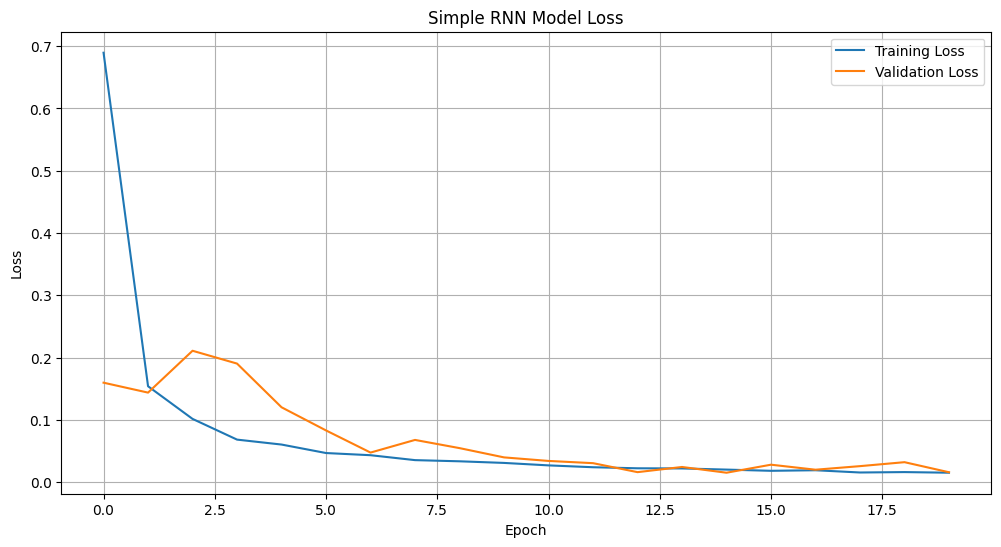

In [25]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(optimal_history.history['loss'], label='Training Loss')
plt.plot(optimal_history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


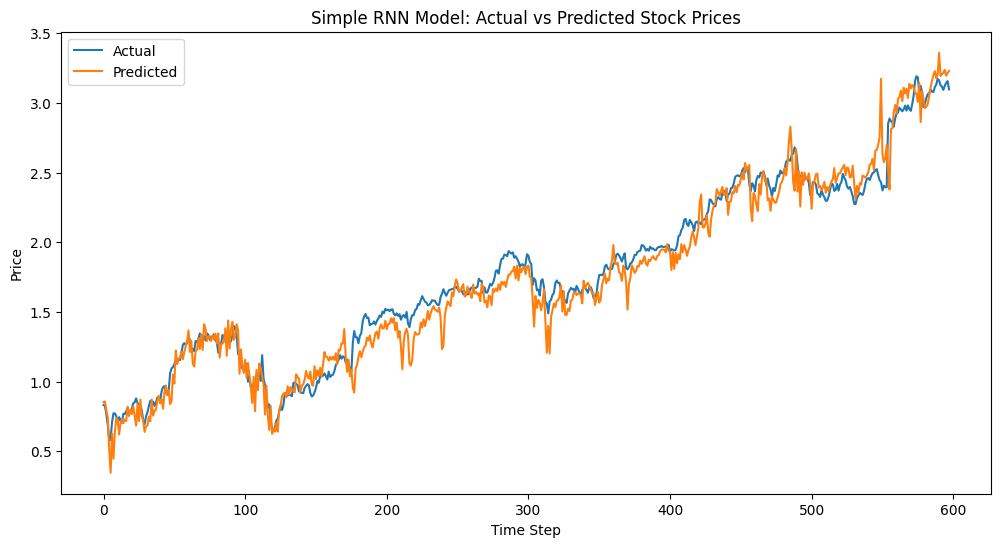

In [26]:
# Predict on the test data and plot

final_predictions = optimal_simple_rnn_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(final_predictions, label='Predicted')
plt.title('Simple RNN Model: Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

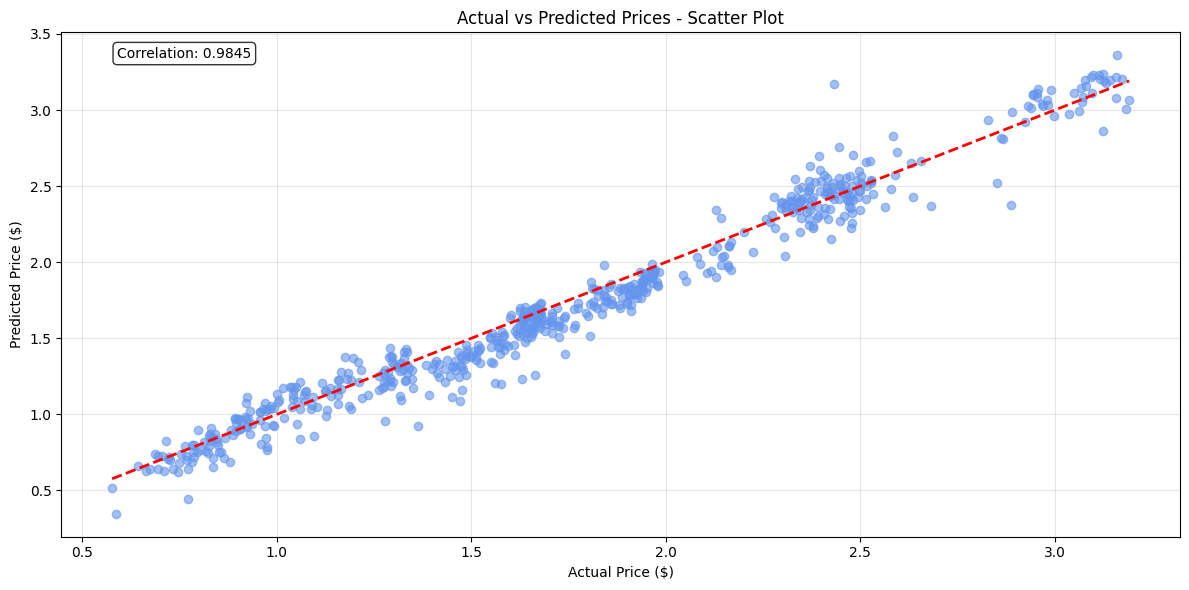

In [27]:
# Plot scatter plot for correlation
plt.figure(figsize=(12, 6))
plt.scatter(y_test, final_predictions, alpha=0.6, color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], 
		 [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices - Scatter Plot')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(y_test.flatten(), final_predictions.flatten())[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes, 
		 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [28]:
# Compute the performance of the model on the testing data set

# Evaluate
final_mse = mean_squared_error(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2score = r2_score(y_test, final_predictions)


print("\n\033[1mFinal Evaluation on Test Set\033[0m")
print(f"Final Mean Squared Error (MSE): {final_mse:.4f}")
print(f"Final Mean Absolute Error (MAE): {final_mae:.4f}")
print(f"Final R2 Score: {final_r2score:.4f}")



Final Evaluation on Test Set
Final Mean Squared Error (MSE): 0.0151
Final Mean Absolute Error (MAE): 0.0942
Final R2 Score: 0.9630


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [29]:
# Define a function to create a model and specify default values for hyperparameters

def build_advanced_rnn(input_shape, model_type='LSTM', units=32, activation='tanh', 
                            dropout_rate=0.2, recurrent_dropout=0.0, learning_rate=0.001, 
                            num_layers=1, return_sequences=False, output_units=1):
    """
    Create an advanced RNN model (LSTM or GRU) for stock price prediction.
    
    Parameters:
    input_shape (tuple): Shape of input data (timesteps, features)
    model_type (str): Type of RNN layer ('LSTM' or 'GRU')
    units (int): Number of units in the RNN layer
    activation (str): Activation function for RNN layer
    dropout_rate (float): Dropout rate for regularization
    recurrent_dropout (float): Recurrent dropout rate
    learning_rate (float): Learning rate for optimizer
    num_layers (int): Number of RNN layers
    return_sequences (bool): Whether to return sequences for stacked layers
    
    Returns:
    Compiled advanced RNN model
    """
    model = Sequential()
    
    # Add RNN layers based on model_type
    for i in range(num_layers):
        if i == 0:  # First layer
            if model_type.upper() == 'LSTM':
                model.add(LSTM(units=units,
                              activation=activation,
                              input_shape=input_shape,
                              return_sequences=return_sequences if num_layers == 1 else True,
                              dropout=dropout_rate,
                              recurrent_dropout=recurrent_dropout))
            elif model_type.upper() == 'GRU':
                model.add(GRU(units=units,
                             activation=activation,
                             input_shape=input_shape,
                             return_sequences=return_sequences if num_layers == 1 else True,
                             dropout=dropout_rate,
                             recurrent_dropout=recurrent_dropout))
            else:
                raise ValueError("model_type must be 'LSTM' or 'GRU'")
        else:  # Subsequent layers
            if model_type.upper() == 'LSTM':
                model.add(LSTM(units=units,
                              activation=activation,
                              return_sequences=return_sequences if i == num_layers-1 else True,
                              dropout=dropout_rate,
                              recurrent_dropout=recurrent_dropout))
            elif model_type.upper() == 'GRU':
                model.add(GRU(units=units,
                             activation=activation,
                             return_sequences=return_sequences if i == num_layers-1 else True,
                             dropout=dropout_rate,
                             recurrent_dropout=recurrent_dropout))
    
    # Add additional dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add Dense output layer (1 unit for single target prediction)
    model.add(Dense(output_units, activation='linear'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='mse',
                 metrics=['mae'])
    
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [30]:
# Find an optimal configuration

def tuned_advanced_rnn(X_train, y_train, X_val, y_val, input_shape, output_units):
    """
    Tune LSTM/GRU model with various hyperparameters.

    Returns:
        Trained model with best config
        Hyperparameters of the best model
    """
    best_val_loss = np.inf
    best_model = None
    best_config = {}

    model_types = ['LSTM', 'GRU']
    rnn_units_list = [32, 64, 128]
    activations = ['tanh', 'relu']
    dropout_rates = [0.1, 0.2]
    learning_rates = [0.001, 0.0005]
    num_layers = [1, 2, 3]

    for model_type in model_types:
        for rnn_units in rnn_units_list:
            for activation in activations:
                for dropout_rate in dropout_rates:
                    for learning_rate in learning_rates:
                        for num_layer in num_layers:
                            print(f"Training {model_type} with units={rnn_units}, activation = {activation}, dropout={dropout_rate}, lr={learning_rate}, number of layers={num_layer}")
    
                            model_adv_rnn = build_advanced_rnn(
                                input_shape=input_shape,
                                model_type=model_type,                           
                                units=rnn_units,
                                activation=activation,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate,
                                num_layers=num_layer,
                                output_units=output_units,
                            )
    
                            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
                            history_adv_rnn = model_adv_rnn.fit(
                                X_train, y_train,
                                validation_data=(X_test, y_test),
                                epochs=25,
                                batch_size=32,
                                callbacks=[early_stop],
                                verbose=0
                            )
    
                            val_loss = min(history_adv_rnn.history['val_loss'])
    
                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                best_model = model_adv_rnn
                                best_config = {
                                    'model_type': model_type,
                                    'rnn_units': rnn_units,
                                    'activation': activation,
                                    'dropout_rate': dropout_rate,
                                    'learning_rate': learning_rate,
                                    'num_layer': num_layer
                                }

    print("\n$ Best configuration found:")
    print(best_config)
    return best_model, best_config


In [31]:
input_shape = X_train.shape[1:]       # (timesteps, features)
output_units = y_train.shape[1]       # e.g., 1 for single value prediction

# Run the hyperparameter tuning
best_model, best_config = tuned_advanced_rnn(X_train, y_train, X_test, y_test, input_shape, output_units)

# Optionally print results again
print("Best model configuration:")
print(best_config)

Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.001, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.001, number of layers=2
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.001, number of layers=3
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.0005, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.0005, number of layers=2
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.0005, number of layers=3
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.001, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.001, number of layers=2
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.001, number of layers=3
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.0005, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.0005, number of layers=2
Train

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [32]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

optimal_config = best_config  # from previous tuning step

# Rebuild the model using the best hyperparameters
optimal_adv_rnn_model = build_advanced_rnn(
    input_shape=X_train.shape[1:],
    model_type=optimal_config['model_type'],
    units=optimal_config['rnn_units'],
    activation=optimal_config['activation'],
    dropout_rate=optimal_config['dropout_rate'],
    learning_rate=optimal_config['learning_rate'],
    num_layers=optimal_config['num_layer'],
    output_units=y_train.shape[1]
)

# Train the model on full training set (train + validation if desired)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimal_adv_rnn_history = optimal_adv_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1  # Show progress
)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0899 - mae: 0.2249 - val_loss: 0.6286 - val_mae: 0.7350
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0176 - mae: 0.1027 - val_loss: 0.1054 - val_mae: 0.2869
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0130 - mae: 0.0892 - val_loss: 0.1075 - val_mae: 0.2926
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108 - mae: 0.0806 - val_loss: 0.0556 - val_mae: 0.2089
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0099 - mae: 0.0756 - val_loss: 0.0550 - val_mae: 0.2091
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - mae: 0.0721 - val_loss: 0.0449 - val_mae: 0.1889
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0079 - mae: 0.0688 - val_loss: 0.0640 - val_mae: 0.2269
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0076 - mae: 0.0684 - val_loss: 0.0326 - val_mae: 0.1577
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.007

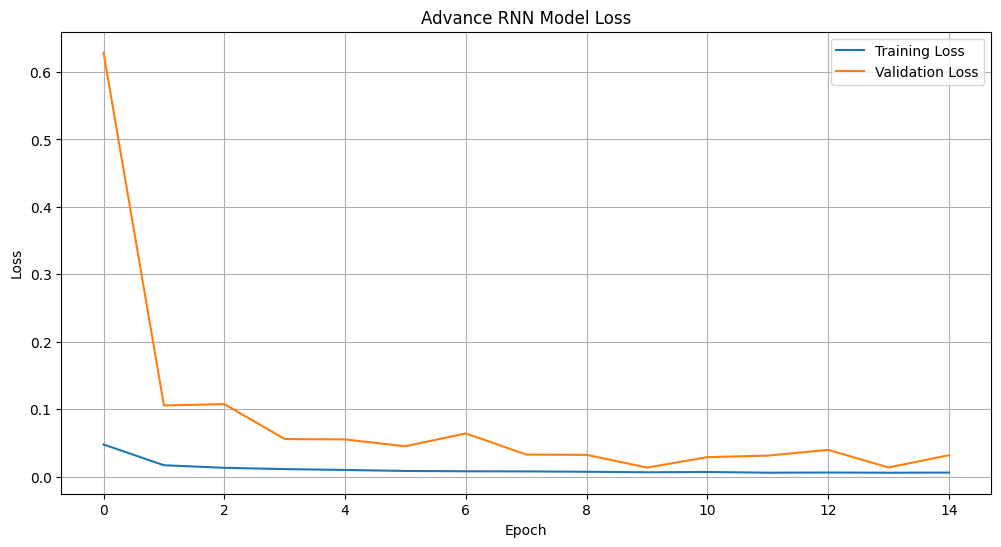

In [33]:
# Plot training & validation loss values

plt.figure(figsize=(12, 6))
plt.plot(optimal_adv_rnn_history.history['loss'], label='Training Loss')
plt.plot(optimal_adv_rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Advance RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Compute the performance of the model on the testing data set

# Predict on the test set
y_pred = optimal_adv_rnn_model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2score = r2_score(y_test, y_pred)

print(f"Test MSE using Advance RNN model: {mse:.6f}")
print(f"Test RMSE using Advance RNN model: {rmse:.6f}")
print(f"Test MAE using Advance RNN model: {mae:.6f}")
print(f"Test R2 Score using Advance RNN model: {r2score:.6f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Test MSE using Advance RNN model: 0.013230
Test RMSE using Advance RNN model: 0.115023
Test MAE using Advance RNN model: 0.093408
Test R2 Score using Advance RNN model: 0.967547


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


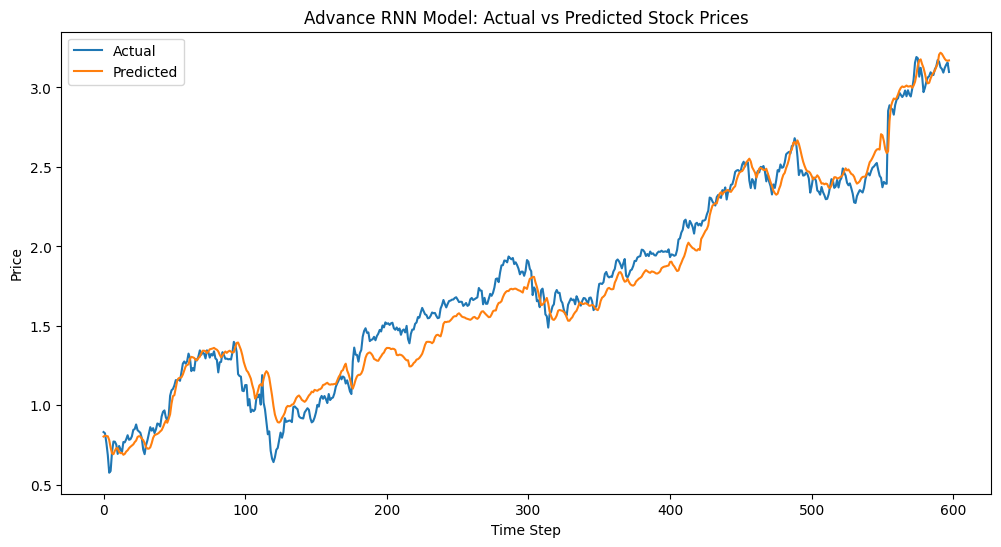

In [35]:
# Predict on the test data
y_pred = optimal_adv_rnn_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Advance RNN Model: Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

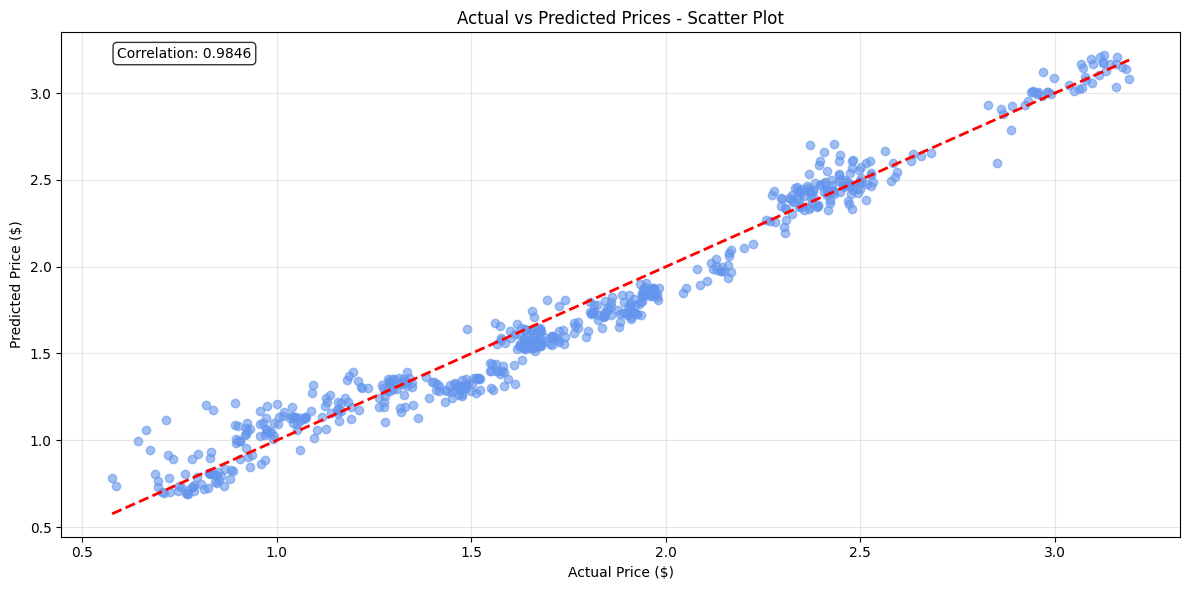

In [36]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], 
		 [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices - Scatter Plot')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(y_test.flatten(), y_pred.flatten())[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes, 
		 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [37]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

# Parameters
window_size_new = 65
window_stride_new = 5
split_ratio_new = 0.8

# list of stock names whose 'Close' values we wish to predict
target_names = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']
print("List of target columns:",target_names)

# Create data
X_train1, y_train1, X_test1, y_test1, scaler_X1 = prepare_rnn_data(
    combined_stock_df,
    target_names=target_names,
    window_size=window_size_new,
    window_stride=window_stride_new,
    train_ratio=split_ratio_new
)
print(f"Shape of \n X_train:{X_train1.shape}\n y_train:{y_train1.shape}\n X_test:{X_test1.shape}\n y_test:{y_test1.shape}")

List of target columns: ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']
Shape of 
 X_train:(472, 65, 20)
 y_train:(472, 4)
 X_test:(119, 65, 20)
 y_test:(119, 4)


In [38]:
# Check the number of data points generated

num_samples_new = X_train1.shape[0] + X_test1.shape[0]
print(f"Total number of windowed data points generated: {num_samples_new}")

Total number of windowed data points generated: 591


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [49]:
# Find an optimal configuration of simple RNN

# Initialise list of configurations
units_list1 = [32, 64, 128]
dropout_rates1 = [0.1, 0.2]
learning_rate_options1 = [0.001, 0.0005]
activation_list1 = ['tanh', 'relu']
input_shape = X_train1.shape[1:]
target_len =  y_train1.shape[1]
results1 = []

# Initialise early stopping
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)

# Iterate through each set of hyperparameter
for units in units_list1:
    for dropout in dropout_rates1:
        for learning_rate in learning_rate_options1: 
            for activation in activation_list1:
                
                # Build a Simple RNN model with current set of hyperparameter
                model1 = build_simple_rnn(
                    units, 
                    activation, 
                    input_shape, 
                    dropout, 
                    target_len, 
                    learning_rate
                )
    
                # Fit the model with ealy stopping
                history1 = model1.fit(
                    X_train1, y_train1, 
                    validation_data=(X_test1, y_test1), 
                    epochs=20, 
                    batch_size=32, 
                    verbose=0, 
                    callbacks=[early_stopping]
                )
    
                # Find the corresponding loss
                train_loss1 = model1.evaluate(X_train1, y_train1, verbose=0)[0]
                val_loss1 = history1.history['val_loss'][-1]
                
                # Get predictions for additional metrics
                y_pred_train1 = model1.predict(X_train1, verbose=0)
                y_pred_val1 = model1.predict(X_test1, verbose=0)
                
                # Calculate additional metrics
                train_mse1 = mean_squared_error(y_train1, y_pred_train1)
                val_mse1 = mean_squared_error(y_test1, y_pred_val1)
                train_mae1 = mean_absolute_error(y_train1, y_pred_train1)
                val_mae1 = mean_absolute_error(y_test1, y_pred_val1)
                
                print(f"Training RNN with {units} units, {dropout} dropout, {learning_rate} learning rate and {activation} activation")
                print(f"  Train Loss: {train_loss1:.6f}, Val Loss: {val_loss1:.6f}")
                print(f"  Train MAE: {train_mae1:.6f}, Val MAE: {val_mae1:.6f}")
    
                # Store the current set of hyperparameter with its val loss 
                results1.append((units, dropout, learning_rate, activation, train_loss1, val_loss1, train_mse1, val_mse1, train_mae1, val_mae1))

Training RNN with 32 units, 0.1 dropout, 0.001 learning rate and tanh activation
  Train Loss: 0.069422, Val Loss: 0.915351
  Train MAE: 0.199962, Val MAE: 0.660991
Training RNN with 32 units, 0.1 dropout, 0.001 learning rate and relu activation
  Train Loss: 0.084173, Val Loss: 0.485706
  Train MAE: 0.223273, Val MAE: 0.510826
Training RNN with 32 units, 0.1 dropout, 0.0005 learning rate and tanh activation
  Train Loss: 0.076601, Val Loss: 0.697284
  Train MAE: 0.213569, Val MAE: 0.672730
Training RNN with 32 units, 0.1 dropout, 0.0005 learning rate and relu activation
  Train Loss: 0.481864, Val Loss: 0.660857
  Train MAE: 0.539846, Val MAE: 0.609398
Training RNN with 32 units, 0.2 dropout, 0.001 learning rate and tanh activation
  Train Loss: 0.120771, Val Loss: 0.764630
  Train MAE: 0.268033, Val MAE: 0.599963
Training RNN with 32 units, 0.2 dropout, 0.001 learning rate and relu activation
  Train Loss: 0.066273, Val Loss: 0.536398
  Train MAE: 0.197966, Val MAE: 0.608642
Training

In [50]:
# storing the results of hyperparameter tuning in dataframe
results_df1 = pd.DataFrame(results1)
results_df1.columns = ['units', 'dropout', 'learning_rate', 'activation', 'train_loss', 'val_loss', 'train_mse', 'val_mse', 'train_mae', 'val_mae']
results_df1.head()

,units,dropout,learning_rate,activation,train_loss,val_loss,train_mse,val_mse,train_mae,val_mae
0,32,0.1,0.0010,tanh,0.069422,0.915351,0.069422,0.887978,0.199962,0.660991
1,32,0.1,0.0010,relu,0.084173,0.485706,0.084173,0.485396,0.223273,0.510826
2,32,0.1,0.0005,tanh,0.076601,0.697284,0.076601,0.688407,0.213569,0.672730
3,32,0.1,0.0005,relu,0.481864,0.660857,0.481864,0.562598,0.539846,0.609398
4,32,0.2,0.0010,tanh,0.120771,0.764630,0.120771,0.699075,0.268033,0.599963


In [51]:
# Find the best configuration

best_config1 = results_df1[results_df1['val_loss']==results_df1['val_loss'].min()]

print("\033[1mBest Simple RNN Configuration:\033[0m")
print("=" * 40)
print(f"Units: {best_config1['units'].values[0]}")
print(f"Dropout rate: {best_config1['dropout'].values[0]:.6f}")
print(f"Learning rate: {best_config1['learning_rate'].values[0]:.6f}")
print(f"Ativation function: {best_config1['activation'].values[0]}")
print(f"Training Loss: {best_config1['train_loss'].values[0]:.6f}")
print(f"Validation Loss: {best_config1['val_loss'].values[0]:.6f}")
print(f"Training MAE: {best_config1['train_mae'].values[0]:.6f}")
print(f"Validation MAE: {best_config1['val_mae'].values[0]:.6f}")



Best Simple RNN Configuration:
Units: 128
Dropout rate: 0.200000
Learning rate: 0.001000
Ativation function: relu
Training Loss: 0.007019
Validation Loss: 0.077973
Training MAE: 0.064423
Validation MAE: 0.205100


In [52]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

print("\033[1mCreating and training the optimal Simple RNN model.\033[0m")
print("=" * 60)

# Extract best hyperparameters
optimal_units1 = int(best_config1['units'].values[0])
optimal_dropout1 = float(best_config1['dropout'].values[0])
optimal_learning_rate1 = float(best_config1['learning_rate'].values[0])
optimal_activation1 = str(best_config1['activation'].values[0])


# Rebuild and train the optimal Simple RNN Model on the full training data
optimal_simple_rnn_model1 = build_simple_rnn(
    units = optimal_units1, 
    activation = optimal_activation1, 
    input_shape = X_train1.shape[1:],
    dropout_rate = optimal_dropout1, 
    target_len =  y_train1.shape[1], 
    learning_rate = optimal_learning_rate1
)

print(f"\033[1mBest Hyperparameters:\033[0m\n {best_config1}")

print("\n\033[1mModel Architecture:\033[0m")
optimal_simple_rnn_model1.summary()

# Train the optimal model with more epochs for better performance
print("\n\033[1mTraining the optimal Simple RNN model.\033[0m")

# Define early stopping again
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model on full training data
optimal_history1 = optimal_simple_rnn_model1.fit(
                    X_train1, y_train1, 
                    validation_data=(X_test1, y_test1), 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[early_stopping]
                )

print("\033[1mTraining completed!\033[0m")



Creating and training the optimal Simple RNN model.
Best Hyperparameters:
     units  dropout  learning_rate activation  train_loss  val_loss  train_mse  \
21    128      0.2          0.001       relu    0.007019  0.077973   0.007019   

     val_mse  train_mae  val_mae  
21  0.075219   0.064423   0.2051  

Model Architecture:


Model: "sequential_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_142 (SimpleRNN)      │ (None, 128)            │        19,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,588 (76.52 KB)

 Trainable params: 19,588 (76.52 KB)

 Non-trainable params: 0 (0.00 B)


Training the optimal Simple RNN model.
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5982 - mae: 0.4993 - val_loss: 0.9761 - val_mae: 0.7942
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1305 - mae: 0.2763 - val_loss: 0.6283 - val_mae: 0.6185
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0986 - mae: 0.2342 - val_loss: 0.5240 - val_mae: 0.5875
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0825 - mae: 0.2029 - val_loss: 0.4043 - val_mae: 0.5284
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0600 - mae: 0.1858 - val_loss: 0.2813 - val_mae: 0.4244
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0519 - mae: 0.1693 - val_loss: 0.2344 - val_mae: 0.3880
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0448 - mae: 0.1605 - val_loss: 0.2077 - val_mae: 0.3598
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0503 - mae: 0.1610 - val_loss: 0.2194 - val_mae: 0.3412
Epoch 9/20
15/15 ━━━━━━━

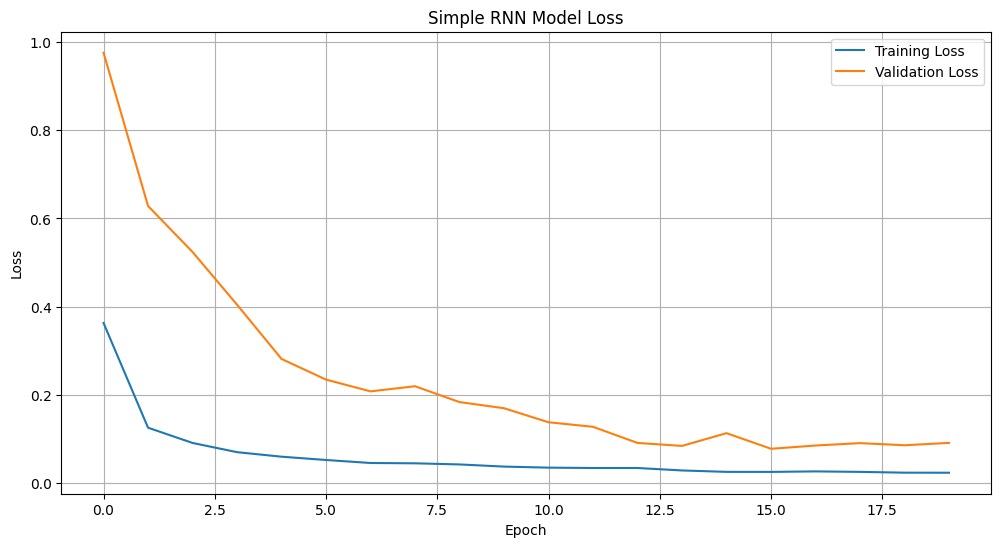

In [53]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(optimal_history1.history['loss'], label='Training Loss')
plt.plot(optimal_history1.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Final Evaluation on Test Set
Final Mean Squared Error (MSE): 0.0775
Final Mean Absolute Error (MAE): 0.2232
Final R2 Score: 0.7205


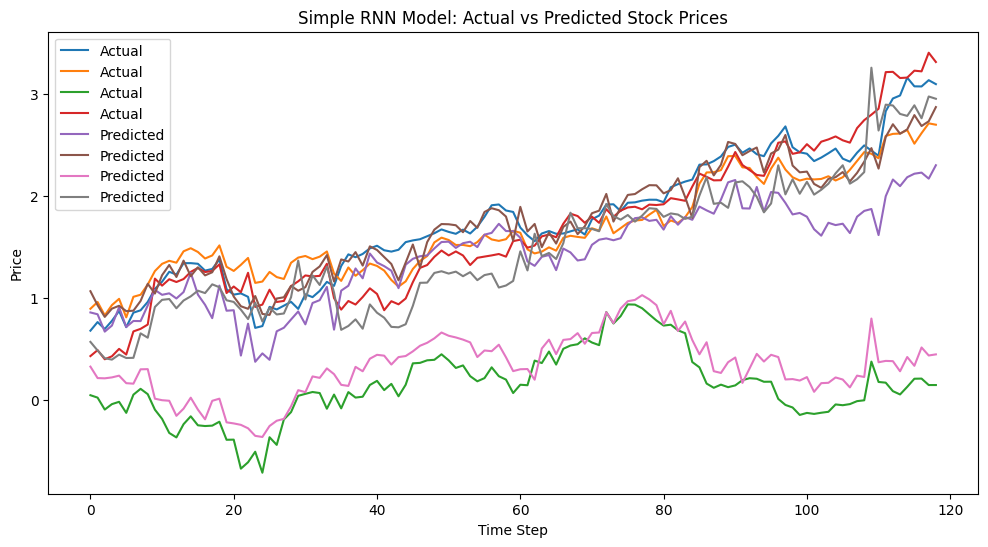

In [54]:
# Compute the performance of the model on the testing data set

# Predict on the test data and plot

final_predictions1 = optimal_simple_rnn_model1.predict(X_test1)

# Evaluate
final_mse1 = mean_squared_error(y_test1, final_predictions1)
final_mae1 = mean_absolute_error(y_test1, final_predictions1)
final_r2score1 = r2_score(y_test1, final_predictions1)


print("\n\033[1mFinal Evaluation on Test Set\033[0m")
print(f"Final Mean Squared Error (MSE): {final_mse1:.4f}")
print(f"Final Mean Absolute Error (MAE): {final_mae1:.4f}")
print(f"Final R2 Score: {final_r2score1:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test1, label='Actual')
plt.plot(final_predictions1, label='Predicted')
plt.title('Simple RNN Model: Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

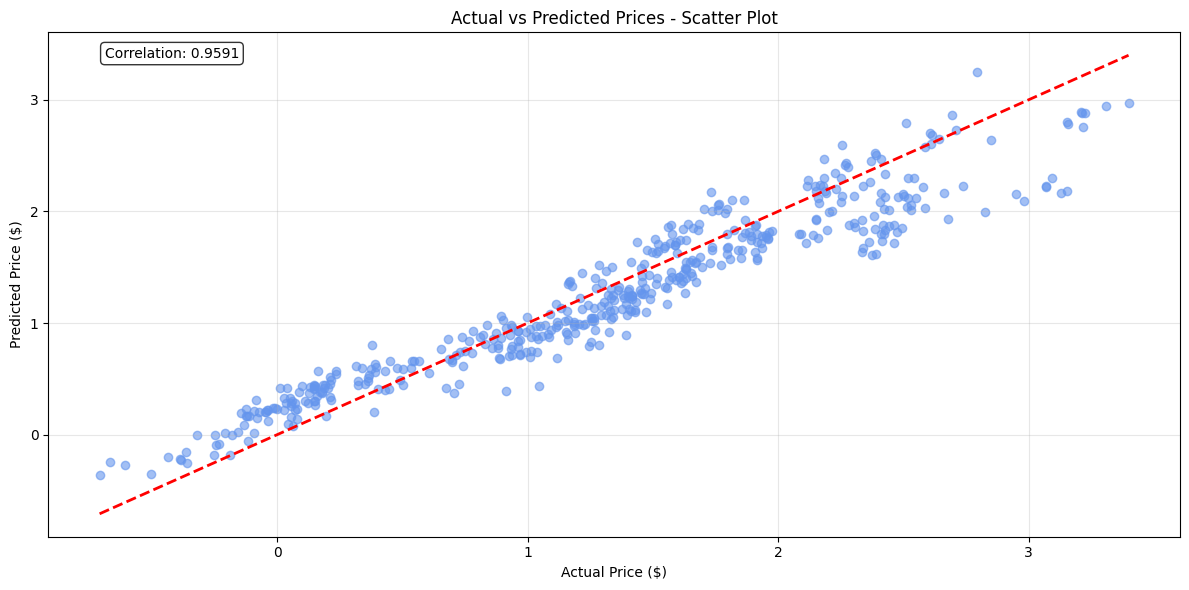

In [55]:
# Plotting the actual vs predicted values for all targets

plt.figure(figsize=(12, 6))
plt.scatter(y_test1, final_predictions1, alpha=0.6, color='cornflowerblue')
plt.plot([y_test1.min(), y_test1.max()], 
		 [y_test1.min(), y_test1.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices - Scatter Plot')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation1 = np.corrcoef(y_test1.flatten(), final_predictions1.flatten())[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation1:.4f}', transform=plt.gca().transAxes, 
		 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [57]:
# Find an optimal configuration of advanced RNN

input_shape = X_train1.shape[1:]       # (timesteps, features)
output_units = y_train1.shape[1]       # e.g., 1 for single value prediction

# Run the hyperparameter tuning
best_model1, best_config1 = tuned_advanced_rnn(X_train1, y_train1, X_test1, y_test1, input_shape, output_units)


Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.001, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.001, number of layers=2
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.001, number of layers=3
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.0005, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.0005, number of layers=2
Training LSTM with units=32, activation = tanh, dropout=0.1, lr=0.0005, number of layers=3
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.001, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.001, number of layers=2
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.001, number of layers=3
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.0005, number of layers=1
Training LSTM with units=32, activation = tanh, dropout=0.2, lr=0.0005, number of layers=2
Train

In [58]:
# Find the best configuration

print("Best model configuration:")
print(best_config1)

Best model configuration:
{'model_type': 'LSTM', 'rnn_units': 128, 'activation': 'relu', 'dropout_rate': 0.1, 'learning_rate': 0.001, 'num_layer': 1}


In [66]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

optimal_config1 = best_config1  # from previous tuning step

# Rebuild the model using the best hyperparameters
optimal_adv_rnn_model1 = build_advanced_rnn(
    input_shape=X_train1.shape[1:],
    model_type=optimal_config1['model_type'],
    units=optimal_config1['rnn_units'],
    activation=optimal_config1['activation'],
    dropout_rate=optimal_config1['dropout_rate'],
    learning_rate=optimal_config1['learning_rate'],
    num_layers=optimal_config1['num_layer'],
    output_units=y_train1.shape[1]
)

# Train the model on full training set (train + validation if desired)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

optimal_adv_rnn_history1 = optimal_adv_rnn_model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1  # Show progress
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.2739 - mae: 0.3993 - val_loss: 187.3461 - val_mae: 5.3995
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0487 - mae: 0.1682 - val_loss: 0.4624 - val_mae: 0.4704
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0336 - mae: 0.1414 - val_loss: 4.2458 - val_mae: 0.8420
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0276 - mae: 0.1265 - val_loss: 0.3332 - val_mae: 0.3805
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0238 - mae: 0.1190 - val_loss: 0.4689 - val_mae: 0.3746
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0235 - mae: 0.1150 - val_loss: 0.0588 - val_mae: 0.1607
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0235 - mae: 0.1166 - val_loss: 0.0837 - val_mae: 0.2045
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0210 - mae: 0.1104 - val_loss: 0.0292 - val_mae: 0.1279
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0

In [67]:
# Compute the performance of the model on the testing data set

# Predict on the test set
y_pred1 = optimal_adv_rnn_model1.predict(X_test1)

# Compute evaluation metrics
mse1 = mean_squared_error(y_test1, y_pred1)
mae1 = mean_absolute_error(y_test1, y_pred1)
rmse1 = np.sqrt(mse1)
r2score1 = r2_score(y_test1, y_pred1)

print(f"Test MSE using Advance RNN model: {mse1:.6f}")
print(f"Test RMSE using Advance RNN model: {rmse1:.6f}")
print(f"Test MAE using Advance RNN model: {mae1:.6f}")
print(f"Test R2 Score using Advance RNN model: {r2score1:.6f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Test MSE using Advance RNN model: 0.029230
Test RMSE using Advance RNN model: 0.170966
Test MAE using Advance RNN model: 0.127885
Test R2 Score using Advance RNN model: 0.868082


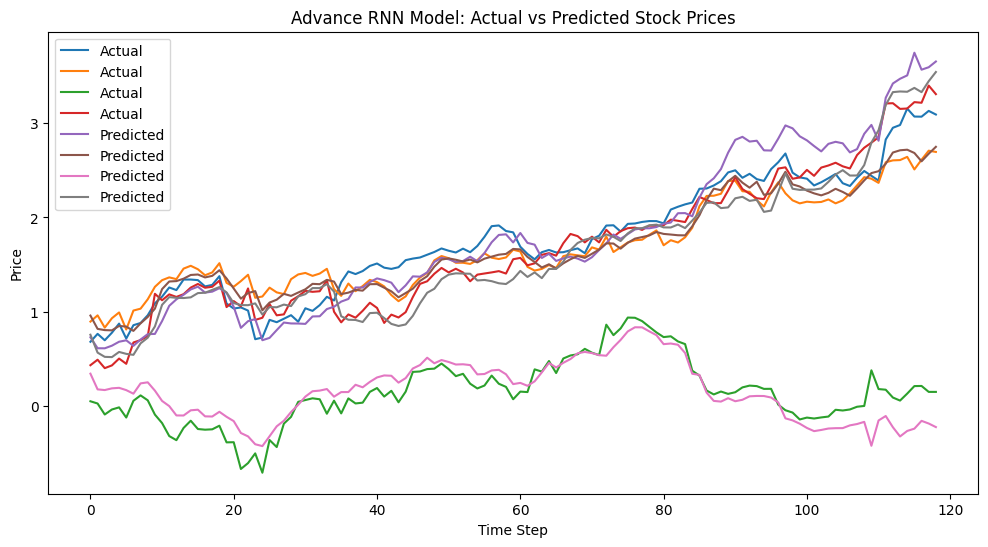

In [68]:
# Plotting the actual vs predicted values for all targets

plt.figure(figsize=(12, 6))
plt.plot(y_test1, label='Actual')
plt.plot(y_pred1, label='Predicted')
plt.title('Advance RNN Model: Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

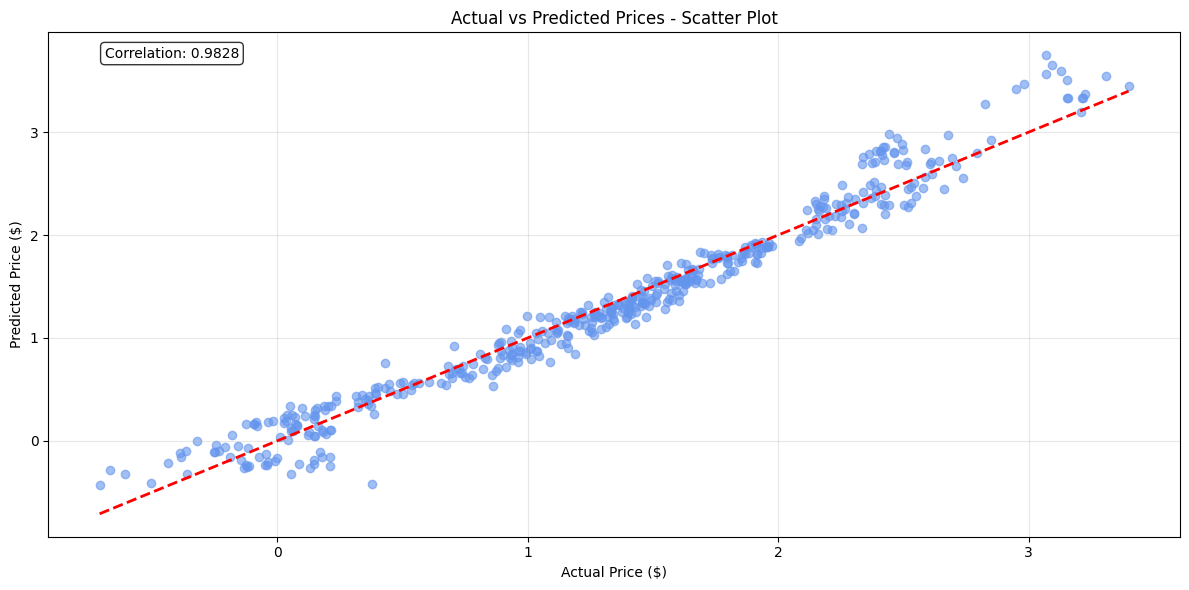

In [69]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test1, y_pred1, alpha=0.6, color='cornflowerblue')
plt.plot([y_test1.min(), y_test1.max()], 
		 [y_test1.min(), y_test1.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices - Scatter Plot')
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation1 = np.corrcoef(y_test1.flatten(), y_pred1.flatten())[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation1:.4f}', transform=plt.gca().transAxes, 
		 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

> ## <span style="color: blue;">Summary</span>
>
> #### <span style="color: blue;">Data Preprocessing & Merging</span>
> <span style="color: blue;"> - Datasets from **four different companies** for Amazon (AMZN), Google (GOOGL), IBM (IBM), and Microsoft (MSFT) were merged in single DataFrame.
> 
> <span style="color: blue;"> - Data spans from **2006 to 2018**, with columns like Open, High, Low, Close, Volume, and Name.
>
> <span style="color: blue;"> - Employed **sliding window techniques** to create time-series samples for supervised learning.
> 
> <span style="color: blue;"> - Normalized the data using **StandardScaler** ensured that different price ranges and vloumes across stocks did not bias the model.
>
>
>  #### <span style="color: blue;">Model Development</span>
> <span style="color: blue;"> - A **Simple Recurrent Neural Network (RNN)** model was built and checked the performance.
> 
> <span style="color: blue;"> - Also **Advnced Recurrent Neural Network (RNN)** model using **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** layers was built and checked the performance.
> 
> <span style="color: blue;"> - Both Simple and Advanced RNN models were built for **multiple target variables** and checked the performance.
> 
> <span style="color: blue;"> - The model can use multiple features (Open, High, Low, Close, Volume) as predictors.
>
> 
> #### <span style="color: blue;">Prediction Strategy</span>
> <span style="color: blue;"> - Predictions were made on test data with all developed models.
> 
> <span style="color: blue;"> - Here, Predictions were made on the **Close** price, which is the most critical indicator for financial decision-making.
>
> 
> #### <span style="color: blue;">Performance Evaluation</span>
> <span style="color: blue;"> - **Training loss and validation loss** were plotted over epochs, showing consistent learning without overfitting.
>
> <span style="color: blue;"> - Visual comparisons between **actual vs predicted closing prices** showed:
>
> <span style="color: blue;"> 1. The model captured the **overall trends and seasonal patterns** of stock prices.
>
> <span style="color: blue;"> 2. Some short-term deviations were present, but **predictions remained directionally accurate**.

> ## <span style="color: blue;">Key Insights</span>
> <span style="color: blue;"> - **Model Selection**: GRU and LSTM units **outperformed** Simple RNNs due to their ability to **retain long-term memory** and handle vanishing gradient issues.
>
> <span style="color: blue;"> - **Hyperparameter Tuning**: Performance was highly sensitive to the number of units, dropout, and activation choices. Optimal configurations typically involved **64 or 128 units**, **ReLU** activations, and **dropout rates between 0.1 and 0.2**.
>
> <span style="color: blue;"> - **Prediction Accuracy**: **GRU/LSTM models** consistently delivered **lower MSE and MAE**, reducing the risk of overfitting by using techniques like dropout and early stopping.


> ## <span style="color: blue;">Performance Comparison</span>
>
> <span style="color: blue;"> - Both model categories were assessed using **Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²)**.

> | Metric                   | Simple RNN (Single Target)      | Advanced RNN (Single Target)   | Simple RNN (Multiple Target)  | Advanced RNN (Multiple Target) |
|--------------------------|---------------------------------|--------------------------------|-------------------------------|---------------------------------|
| **Model Type**           |  ---                            | GRU                            |  ---                          | LSTM                            |
| **Units**                | 32                              | 64                             | 128                           | 128                             |
| **Dropout Rate**         | 0.2                             | 0.1                            | 0.2                           | 0.1                             |
| **Learning Rate**        | 0.001                           | 0.0005                         | 0.001                         | 0.001                           |
| **Activation Function**  | ReLU                            | ReLU                           | ReLU                          | ReLU                            |
| **MSE**                  | 0.0151                          | 0.0132                         | 0.0775                        | 0.0292                          |
| **MAE**                  | 0.0942                          | 0.0934                         | 0.2232                        | 0.1278                          |
| **R2 Score**             | 0.9630                          | 0.9675                         | 0.7205                        | 0.8680                          |
| **Correlation Act vs Pred**| 0.9845                        | 0.9846                         | 0.9591                        | 0.9828                          |

> <span style="color: blue;"> - **Advanced RNN models significantly outperformed** Simple RNNs, particularly in terms of **lower prediction errors** and **higher R²**, indicating superior generalization.

> ## <span style="color: blue;">Conclusion</span>
>
> <span style="color: blue;"> - The **tuned GRU model** emerged as the top performer, delivering:
> 
> <span style="color: blue;"> 1. **Accurate and robust** stock price forecasts
>
> <span style="color: blue;"> 2. **Minimal overfitting**, thanks to proper regularization and early stopping
>
> <span style="color: blue;"> - **Hyperparameter tuning** played a **critical role** in achieving optimal model performance.
>
> <span style="color: blue;"> - Overall, **Advanced models (GRU, LSTM)** consistently outperformed Simple RNNs, demonstrating better learning, prediction accuracy, and generalization ability.
>
> 

> ## <span style="color: blue;"> Business Insight</span>
>
> <span style="color: blue;"> - The developed models demonstrated **reliable short-term forecasts** of stock closing prices.
>
> <span style="color: blue;"> - Such predictive capabilities have direct real-world applications in:
>
> <span style="color: blue;"> 1. **Risk Management**: Enabling better assessment of potential losses.
> 
> <span style="color: blue;"> 2. **Portfolio Optimization**: Informing asset allocation strategies.
>
> <span style="color: blue;"> 3. **Trading Signal Generation**: Supporting data-driven buy/sell decisions.
>
> <span style="color: blue;"> - By capturing both trends and seasonality, the models can serve as decision-support tools for **quantitative analysts and financial strategists**.